<a href="https://colab.research.google.com/github/PondKann/CXR_classification_model/blob/main/Inception_Train_Test_3class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1) Pretrained // Sampling Abnormal  รันแล้วยังไม่กรอก

2) 0-100 // Sampling Abnormal  รันแล้วยังไม่กรอก

#### import

In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import cv2
import numpy as np
import pandas as pd
from torchsummary import summary
from skimage.io import imread, imsave
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import PIL
from PIL import Image


In [2]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from imutils import paths
import argparse

from sklearn.model_selection import KFold
from sklearn import metrics
from scipy.stats import zscore


import matplotlib.image as mpimg
from matplotlib.pyplot import savefig

import itertools
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

#### Load data // KKU

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_dir = '/content/drive/My Drive/Senior Project/CXR Image3class/Image'

train 3 class

In [5]:
Normal151_dir = os.path.join(data_dir,'Normal151')
TB150_dir = os.path.join(data_dir,'TB150')
CA150_dir = os.path.join(data_dir,'CA150')

All_3class_dir = os.path.join(data_dir,'All_3class')

#### Load data // Gmail

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/My Drive/Senior Project/CXR Image3class'

train 3 class

In [ ]:
Normal151_dir = os.path.join(data_dir,'Normal151')
TB150_dir = os.path.join(data_dir,'TB150')
CA150_dir = os.path.join(data_dir,'CA150')

All_3class_dir = os.path.join(data_dir,'All_3class')

####Data train 3 class  
ข้อมูลใน All_3class_dir รวมภาพทั้ง 3 คลาส รวม 450 ภาพ TB150, Normal151 (เอามาแค่150) และ CA150 (CA คือ lungcancer)

In [6]:
Normal151_dir = os.path.join(data_dir,'Normal151')
TB150_dir = os.path.join(data_dir,'TB150')
CA150_dir = os.path.join(data_dir,'CA150')

All_3class_dir = os.path.join(data_dir,'All_3class')

In [7]:
normal = []
for i in range(len(os.listdir(Normal151_dir))):
    img = os.listdir(Normal151_dir)[i]
    normal.append(img)
    
tnormal = pd.DataFrame({'ImageName':[normal][0],
                                       'NameType': "Normal" ,
                                       'NumberType': 0                      })

In [8]:
tuberculosis = []
for i in range(len(os.listdir(TB150_dir))):
    img = os.listdir(TB150_dir)[i]
    tuberculosis.append(img)

ttuberculosis = pd.DataFrame({'ImageName':[tuberculosis][0],
                                       'NameType': "Tuberculosis" ,
                                       'NumberType': 1                        })

In [9]:
lungcancer = []
for i in range(len(os.listdir(CA150_dir))):
    img = os.listdir(CA150_dir)[i]
    lungcancer.append(img)

tlungcancer = pd.DataFrame({'ImageName':[lungcancer][0],
                                       'NameType': "Lungcancer" ,
                                       'NumberType': 2                        })

In [10]:
data_train3 = pd.concat([tnormal[:-1], ttuberculosis, tlungcancer])
data_train3[-3:]

,ImageName,NameType,NumberType
147,ca2.jpg,Lungcancer,2
148,ca26.jpg,Lungcancer,2
149,ca8.jpg,Lungcancer,2


# Pretrained  

#### 1 soft pre bi 
0.707  


In [ ]:
BS = 1
filepath = "model1_soft_pre_bi.h5"                  ##

train_img_Incep = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (299, 299))                                      
    train_img_Incep.append(img)
data_Incep = np.array(train_img_Incep, dtype="float32") / 255.0

labels_Incep = np.array(data_train3[['NameType']] )        
labels_Incep.shape = (len(labels_Incep),) 
le_Incep = LabelEncoder()                                                                     
labels_Incep = le_Incep.fit_transform(labels_Incep)                                         
labels_Incep = to_categorical(labels_Incep, num_classes=3)                   

aug = ImageDataGenerator( rotation_range=15,	width_shift_range=0.1, 	height_shift_range=0.1,
		shear_range=0.15, 	horizontal_flip=True, 	fill_mode="nearest")
                                                                                                           ## 
callback = EarlyStopping( monitor= "val_accuracy",    patience=15,       mode="max")

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
                                                                                                            ##
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,   patience=6,     verbose=1, mode='max', min_lr=0.00001)

(x_train_Incep, x_test_Incep, y_train_Incep, y_test_Incep ) = train_test_split(data_Incep, labels_Incep,
	                                                                                                test_size=0.25, random_state=40)

100%|██████████| 450/450 [04:08<00:00,  1.81it/s]


In [ ]:
base_model_Incep = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3), include_top=False, weights="imagenet")
base_model_Incep.trainable = False


#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Incep.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Incep = tf.keras.models.Model(inputs=base_model_Incep.input, outputs=prediction_layer)

model_Incep.compile(optimizer=RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

H_Incep = model_Incep.fit( x=aug.flow(x_train_Incep, y_train_Incep, batch_size=BS),
	                                            validation_data=(x_test_Incep, y_test_Incep),
	                                            steps_per_epoch=len(x_train_Incep) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

pred_Incep = model_Incep.predict(x_test_Incep)

print(classification_report(y_test_Incep.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Incep.argmax(axis=1),  
                                        target_names=le_Incep.classes_))


87924736/87910968 [==============================] - 2s 0us/step
Epoch 1/100
336/337 [============================>.] - ETA: 0s - loss: 0.6553 - accuracy: 0.3393
Epoch 1: val_accuracy improved from -inf to 0.40708, saving model to model1_soft_pre_bi.h5
337/337 [==============================] - 37s 67ms/step - loss: 0.6544 - accuracy: 0.3412 - val_loss: 0.6258 - val_accuracy: 0.4071 - lr: 1.0000e-04
Epoch 2/100
336/337 [============================>.] - ETA: 0s - loss: 0.6068 - accuracy: 0.4881
Epoch 2: val_accuracy improved from 0.40708 to 0.51327, saving model to model1_soft_pre_bi.h5
337/337 [==============================] - 15s 45ms/step - loss: 0.6067 - accuracy: 0.4896 - val_loss: 0.5937 - val_accuracy: 0.5133 - lr: 1.0000e-04
Epoch 3/100
336/337 [============================>.] - ETA: 0s - loss: 0.5779 - accuracy: 0.5506
Epoch 3: val_accuracy improved from 0.51327 to 0.57522, saving model to model1_soft_pre_bi.h5
337/337 [==============================] - 15s 45ms/step - loss: 

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

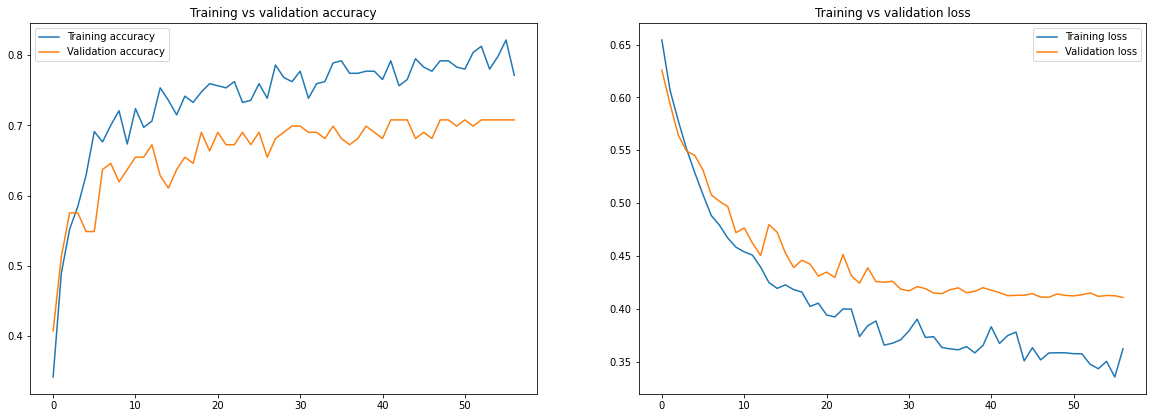

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H_Incep                            ##
pred_Dense = pred_Incep                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[25  3  8]
 [ 0 40  0]
 [13  9 15]]
Normalized confusion matrix
[[0.69 0.08 0.22]
 [0.   1.   0.  ]
 [0.35 0.24 0.41]]


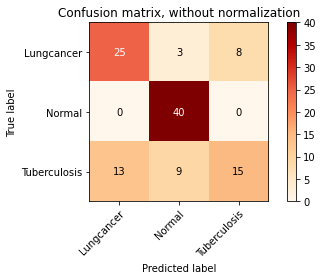

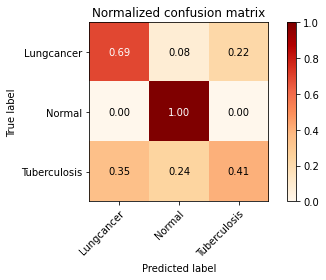

In [ ]:
y_pred = pred_Incep.argmax(axis=1)            ##
y_true  = y_test_Incep.argmax(axis=1)
y_test = y_test_Incep.argmax(axis=1)
class_names = le_Incep.classes_
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [ ]:
model = load_model(filepath)

In [ ]:
pred_model = model.predict(x_test_Incep)

print(classification_report(y_test_Incep.argmax(axis=1),   pred_model.argmax(axis=1), target_names=le_Incep.classes_))

              precision    recall  f1-score   support

  Lungcancer       0.66      0.69      0.68        36
      Normal       0.77      1.00      0.87        40
Tuberculosis       0.65      0.41      0.50        37

    accuracy                           0.71       113
   macro avg       0.69      0.70      0.68       113
weighted avg       0.70      0.71      0.69       113



Confusion matrix, without normalization
[[25  3  8]
 [ 0 40  0]
 [13  9 15]]
Normalized confusion matrix
[[0.69 0.08 0.22]
 [0.   1.   0.  ]
 [0.35 0.24 0.41]]


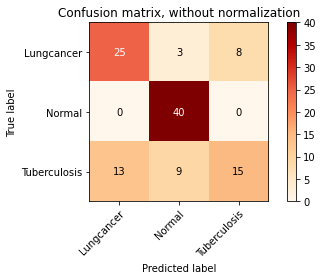

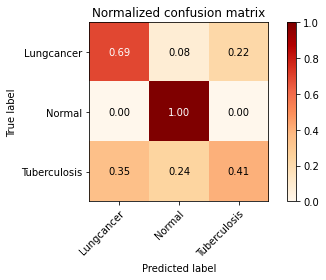

In [ ]:
y_pred = pred_model.argmax(axis=1)            ##
y_true  = y_test_Incep.argmax(axis=1)
y_test = y_test_Incep.argmax(axis=1)

class_names = le_Incep.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 1 soft pre bi adam  
0.735


In [ ]:
BS = 1
filepath = "model1_soft_pre_bi_adam.h5"                  ##

train_img_Incep = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (299, 299))                                      
    train_img_Incep.append(img)
data_Incep = np.array(train_img_Incep, dtype="float32") / 255.0

labels_Incep = np.array(data_train3[['NameType']] )        
labels_Incep.shape = (len(labels_Incep),) 
le_Incep = LabelEncoder()                                                                     
labels_Incep = le_Incep.fit_transform(labels_Incep)                                         
labels_Incep = to_categorical(labels_Incep, num_classes=3)                   

aug = ImageDataGenerator( rotation_range=15,	width_shift_range=0.1, 	height_shift_range=0.1,
		shear_range=0.15, 	horizontal_flip=True, 	fill_mode="nearest")
                                                                                                           ## 
callback = EarlyStopping( monitor= "val_accuracy",    patience=15,       mode="max")

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
                                                                                                            ##
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,   patience=6,     verbose=1, mode='max', min_lr=0.00001)

(x_train_Incep, x_test_Incep, y_train_Incep, y_test_Incep ) = train_test_split(data_Incep, labels_Incep,
	                                                                                                test_size=0.25, random_state=40)

100%|██████████| 450/450 [00:05<00:00, 81.70it/s] 


In [ ]:
base_model_Incep = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3), include_top=False, weights="imagenet")
base_model_Incep.trainable = False


#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Incep.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Incep = tf.keras.models.Model(inputs=base_model_Incep.input, outputs=prediction_layer)

model_Incep.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

H_Incep = model_Incep.fit( x=aug.flow(x_train_Incep, y_train_Incep, batch_size=BS),
	                                            validation_data=(x_test_Incep, y_test_Incep),
	                                            steps_per_epoch=len(x_train_Incep) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

pred_Incep = model_Incep.predict(x_test_Incep)

print(classification_report(y_test_Incep.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Incep.argmax(axis=1),  
                                        target_names=le_Incep.classes_))


Epoch 1/100
337/337 [==============================] - ETA: 0s - loss: 0.6444 - accuracy: 0.3591
Epoch 1: val_accuracy improved from -inf to 0.53982, saving model to model1_soft_pre_bi_adam.h5
337/337 [==============================] - 21s 48ms/step - loss: 0.6444 - accuracy: 0.3591 - val_loss: 0.6171 - val_accuracy: 0.5398 - lr: 1.0000e-04
Epoch 2/100
336/337 [============================>.] - ETA: 0s - loss: 0.5897 - accuracy: 0.5179
Epoch 2: val_accuracy did not improve from 0.53982
337/337 [==============================] - 14s 42ms/step - loss: 0.5891 - accuracy: 0.5193 - val_loss: 0.5817 - val_accuracy: 0.5221 - lr: 1.0000e-04
Epoch 3/100
336/337 [============================>.] - ETA: 0s - loss: 0.5608 - accuracy: 0.5863
Epoch 3: val_accuracy improved from 0.53982 to 0.54867, saving model to model1_soft_pre_bi_adam.h5
337/337 [==============================] - 15s 44ms/step - loss: 0.5607 - accuracy: 0.5875 - val_loss: 0.5762 - val_accuracy: 0.5487 - lr: 1.0000e-04
Epoch 4/100
3

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

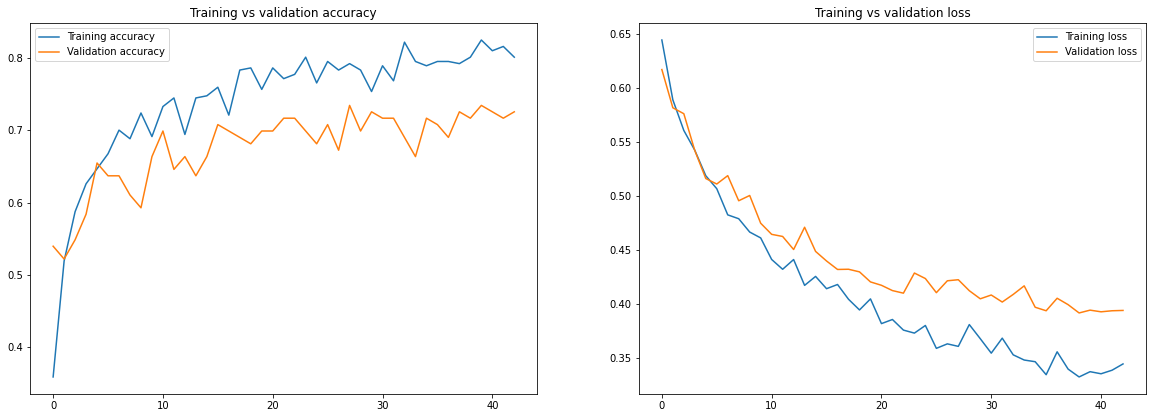

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H_Incep                            ##
pred_Dense = pred_Incep                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[27  3  6]
 [ 0 40  0]
 [14  8 15]]
Normalized confusion matrix
[[0.75 0.08 0.17]
 [0.   1.   0.  ]
 [0.38 0.22 0.41]]


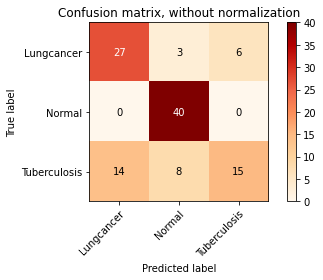

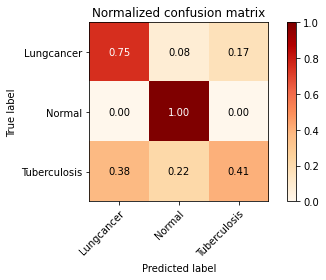

In [ ]:
y_pred = pred_Incep.argmax(axis=1)            ##
y_true  = y_test_Incep.argmax(axis=1)
y_test = y_test_Incep.argmax(axis=1)
class_names = le_Incep.classes_
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [ ]:
model = load_model(filepath)

In [ ]:
pred_model = model.predict(x_test_Incep)

print(classification_report(y_test_Incep.argmax(axis=1),   pred_model.argmax(axis=1), target_names=le_Incep.classes_))

              precision    recall  f1-score   support

  Lungcancer       0.79      0.53      0.63        36
      Normal       0.78      1.00      0.88        40
Tuberculosis       0.63      0.65      0.64        37

    accuracy                           0.73       113
   macro avg       0.74      0.73      0.72       113
weighted avg       0.74      0.73      0.72       113



Confusion matrix, without normalization
[[19  3 14]
 [ 0 40  0]
 [ 5  8 24]]
Normalized confusion matrix
[[0.53 0.08 0.39]
 [0.   1.   0.  ]
 [0.14 0.22 0.65]]


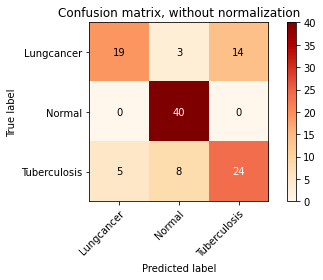

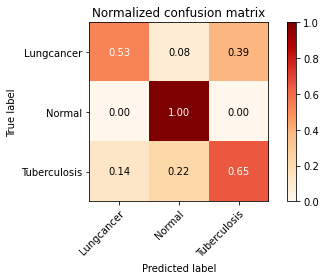

In [ ]:
y_pred = pred_model.argmax(axis=1)            ##
y_true  = y_test_Incep.argmax(axis=1)
y_test = y_test_Incep.argmax(axis=1)

class_names = le_Incep.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 8 soft pre bi   
0.673


In [ ]:
BS = 8
filepath = "model8_soft_pre_bi.h5"                  ##

train_img_Incep = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (299, 299))                                      
    train_img_Incep.append(img)
data_Incep = np.array(train_img_Incep, dtype="float32") / 255.0

labels_Incep = np.array(data_train3[['NameType']] )        
labels_Incep.shape = (len(labels_Incep),) 
le_Incep = LabelEncoder()                                                                     
labels_Incep = le_Incep.fit_transform(labels_Incep)                                         
labels_Incep = to_categorical(labels_Incep, num_classes=3)                   

aug = ImageDataGenerator( rotation_range=15,	width_shift_range=0.1, 	height_shift_range=0.1,
		shear_range=0.15, 	horizontal_flip=True, 	fill_mode="nearest")
                                                                                                           ## 
callback = EarlyStopping( monitor= "val_accuracy",    patience=15,       mode="max")

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
                                                                                                            ##
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,   patience=6,     verbose=1, mode='max', min_lr=0.00001)

(x_train_Incep, x_test_Incep, y_train_Incep, y_test_Incep ) = train_test_split(data_Incep, labels_Incep,
	                                                                                                test_size=0.25, random_state=40)

100%|██████████| 450/450 [00:05<00:00, 81.99it/s] 


In [ ]:
base_model_Incep = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3), include_top=False, weights="imagenet")
base_model_Incep.trainable = False


#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Incep.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Incep = tf.keras.models.Model(inputs=base_model_Incep.input, outputs=prediction_layer)

model_Incep.compile(optimizer=RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

H_Incep = model_Incep.fit( x=aug.flow(x_train_Incep, y_train_Incep, batch_size=BS),
	                                            validation_data=(x_test_Incep, y_test_Incep),
	                                            steps_per_epoch=len(x_train_Incep) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

pred_Incep = model_Incep.predict(x_test_Incep)

print(classification_report(y_test_Incep.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Incep.argmax(axis=1),  
                                        target_names=le_Incep.classes_))


Epoch 1/100
42/42 [==============================] - ETA: 0s - loss: 0.6520 - accuracy: 0.3556
Epoch 1: val_accuracy improved from -inf to 0.29204, saving model to model8_soft_pre_bi.h5
42/42 [==============================] - 18s 270ms/step - loss: 0.6520 - accuracy: 0.3556 - val_loss: 0.6533 - val_accuracy: 0.2920 - lr: 1.0000e-04
Epoch 2/100
42/42 [==============================] - ETA: 0s - loss: 0.6229 - accuracy: 0.4468
Epoch 2: val_accuracy improved from 0.29204 to 0.37168, saving model to model8_soft_pre_bi.h5
42/42 [==============================] - 10s 253ms/step - loss: 0.6229 - accuracy: 0.4468 - val_loss: 0.6409 - val_accuracy: 0.3717 - lr: 1.0000e-04
Epoch 3/100
42/42 [==============================] - ETA: 0s - loss: 0.6148 - accuracy: 0.4498
Epoch 3: val_accuracy improved from 0.37168 to 0.38053, saving model to model8_soft_pre_bi.h5
42/42 [==============================] - 10s 237ms/step - loss: 0.6148 - accuracy: 0.4498 - val_loss: 0.6306 - val_accuracy: 0.3805 - lr: 

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

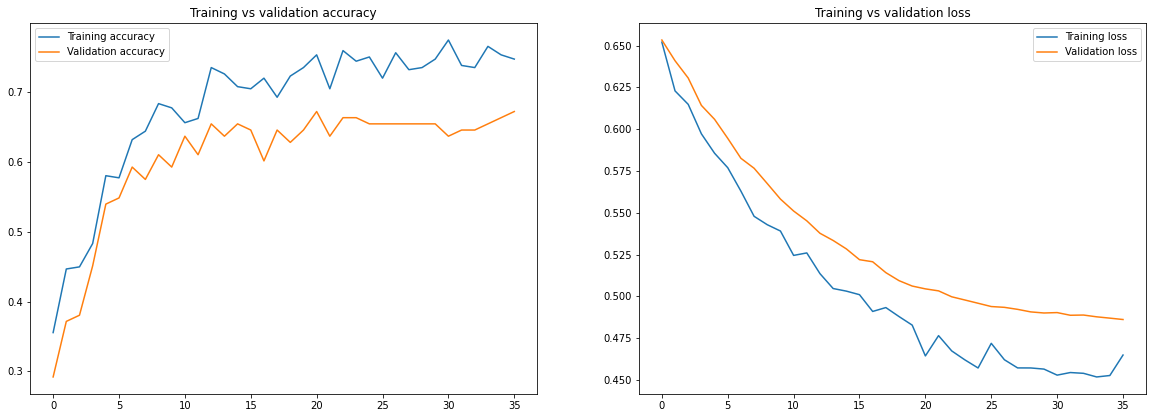

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H_Incep                            ##
pred_Dense = pred_Incep                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[22  3 11]
 [ 0 39  1]
 [12 10 15]]
Normalized confusion matrix
[[0.61 0.08 0.31]
 [0.   0.97 0.03]
 [0.32 0.27 0.41]]


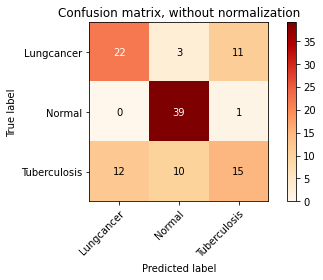

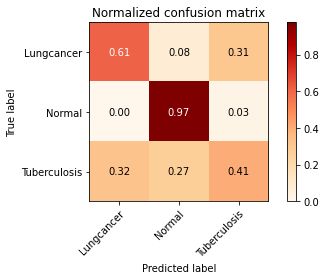

In [ ]:
y_pred = pred_Incep.argmax(axis=1)            ##
y_true  = y_test_Incep.argmax(axis=1)
y_test = y_test_Incep.argmax(axis=1)
class_names = le_Incep.classes_
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [ ]:
model = load_model(filepath)

In [ ]:
pred_model = model.predict(x_test_Incep)

print(classification_report(y_test_Incep.argmax(axis=1),   pred_model.argmax(axis=1), target_names=le_Incep.classes_))

              precision    recall  f1-score   support

  Lungcancer       0.65      0.72      0.68        36
      Normal       0.72      0.95      0.82        40
Tuberculosis       0.60      0.32      0.42        37

    accuracy                           0.67       113
   macro avg       0.66      0.67      0.64       113
weighted avg       0.66      0.67      0.65       113



Confusion matrix, without normalization
[[26  3  7]
 [ 1 38  1]
 [13 12 12]]
Normalized confusion matrix
[[0.72 0.08 0.19]
 [0.03 0.95 0.03]
 [0.35 0.32 0.32]]


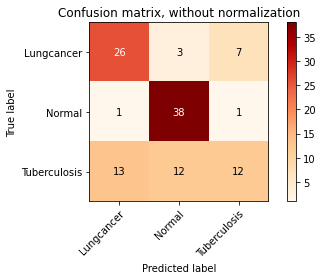

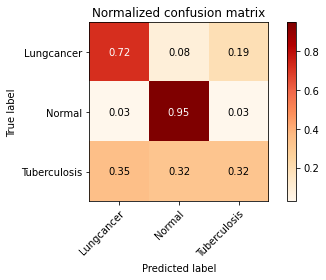

In [ ]:
y_pred = pred_model.argmax(axis=1)            ##
y_true  = y_test_Incep.argmax(axis=1)
y_test = y_test_Incep.argmax(axis=1)

class_names = le_Incep.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 8 soft pre bi  adam
0.655


In [ ]:
BS = 8
filepath = "model8_soft_pre_bi_adam.h5"                  ##

train_img_Incep = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (299, 299))                                      
    train_img_Incep.append(img)
data_Incep = np.array(train_img_Incep, dtype="float32") / 255.0

labels_Incep = np.array(data_train3[['NameType']] )        
labels_Incep.shape = (len(labels_Incep),) 
le_Incep = LabelEncoder()                                                                     
labels_Incep = le_Incep.fit_transform(labels_Incep)                                         
labels_Incep = to_categorical(labels_Incep, num_classes=3)                   

aug = ImageDataGenerator( rotation_range=15,	width_shift_range=0.1, 	height_shift_range=0.1,
		shear_range=0.15, 	horizontal_flip=True, 	fill_mode="nearest")
                                                                                                           ## 
callback = EarlyStopping( monitor= "val_accuracy",    patience=15,       mode="max")

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
                                                                                                            ##
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,   patience=6,     verbose=1, mode='max', min_lr=0.00001)

(x_train_Incep, x_test_Incep, y_train_Incep, y_test_Incep ) = train_test_split(data_Incep, labels_Incep,
	                                                                                                test_size=0.25, random_state=40)

100%|██████████| 450/450 [00:05<00:00, 83.12it/s] 


In [ ]:
base_model_Incep = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3), include_top=False, weights="imagenet")
base_model_Incep.trainable = False


#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Incep.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Incep = tf.keras.models.Model(inputs=base_model_Incep.input, outputs=prediction_layer)

model_Incep.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

H_Incep = model_Incep.fit( x=aug.flow(x_train_Incep, y_train_Incep, batch_size=BS),
	                                            validation_data=(x_test_Incep, y_test_Incep),
	                                            steps_per_epoch=len(x_train_Incep) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

pred_Incep = model_Incep.predict(x_test_Incep)

print(classification_report(y_test_Incep.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Incep.argmax(axis=1),  
                                        target_names=le_Incep.classes_))


Epoch 1/100
42/42 [==============================] - ETA: 0s - loss: 0.6766 - accuracy: 0.3343
Epoch 1: val_accuracy improved from -inf to 0.36283, saving model to model8_soft_pre_bi_adam.h5
42/42 [==============================] - 17s 278ms/step - loss: 0.6766 - accuracy: 0.3343 - val_loss: 0.6357 - val_accuracy: 0.3628 - lr: 1.0000e-04
Epoch 2/100
42/42 [==============================] - ETA: 0s - loss: 0.6231 - accuracy: 0.4377
Epoch 2: val_accuracy improved from 0.36283 to 0.41593, saving model to model8_soft_pre_bi_adam.h5
42/42 [==============================] - 10s 238ms/step - loss: 0.6231 - accuracy: 0.4377 - val_loss: 0.6254 - val_accuracy: 0.4159 - lr: 1.0000e-04
Epoch 3/100
42/42 [==============================] - ETA: 0s - loss: 0.6131 - accuracy: 0.4407
Epoch 3: val_accuracy improved from 0.41593 to 0.44248, saving model to model8_soft_pre_bi_adam.h5
42/42 [==============================] - 10s 238ms/step - loss: 0.6131 - accuracy: 0.4407 - val_loss: 0.6128 - val_accuracy

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

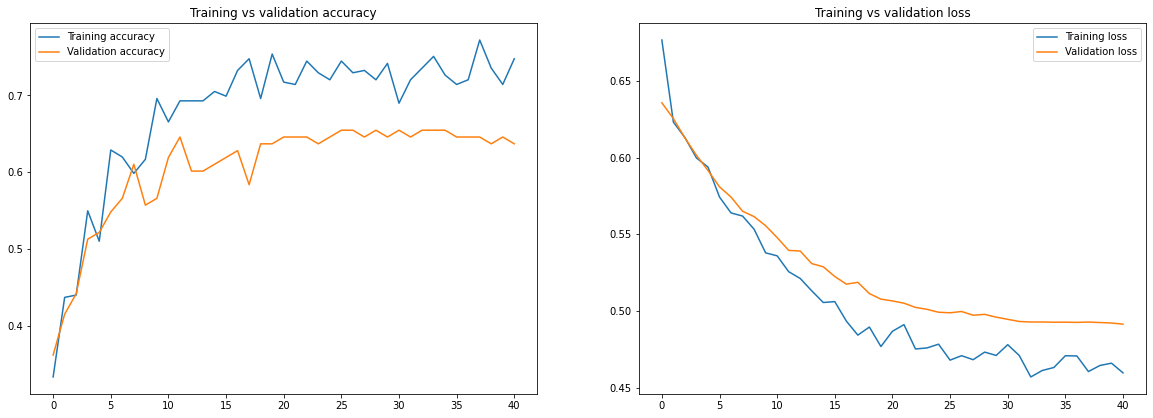

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H_Incep                            ##
pred_Dense = pred_Incep                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[19  8  9]
 [ 0 40  0]
 [11 13 13]]
Normalized confusion matrix
[[0.53 0.22 0.25]
 [0.   1.   0.  ]
 [0.3  0.35 0.35]]


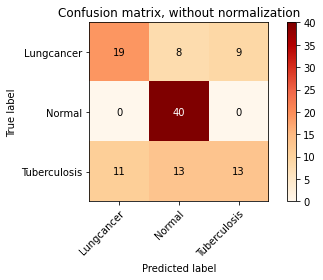

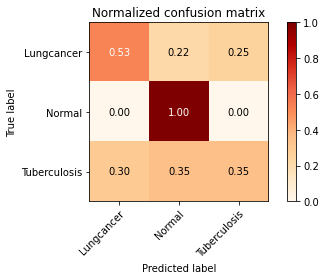

In [ ]:
y_pred = pred_Incep.argmax(axis=1)            ##
y_true  = y_test_Incep.argmax(axis=1)
y_test = y_test_Incep.argmax(axis=1)
class_names = le_Incep.classes_
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [ ]:
model = load_model(filepath)

In [ ]:
pred_model = model.predict(x_test_Incep)

print(classification_report(y_test_Incep.argmax(axis=1),   pred_model.argmax(axis=1), target_names=le_Incep.classes_))

              precision    recall  f1-score   support

  Lungcancer       0.64      0.58      0.61        36
      Normal       0.68      1.00      0.81        40
Tuberculosis       0.62      0.35      0.45        37

    accuracy                           0.65       113
   macro avg       0.64      0.64      0.62       113
weighted avg       0.65      0.65      0.63       113



Confusion matrix, without normalization
[[21  7  8]
 [ 0 40  0]
 [12 12 13]]
Normalized confusion matrix
[[0.58 0.19 0.22]
 [0.   1.   0.  ]
 [0.32 0.32 0.35]]


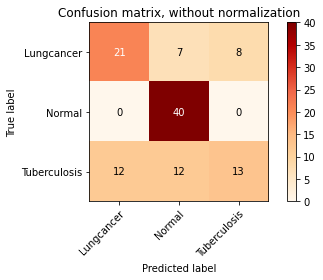

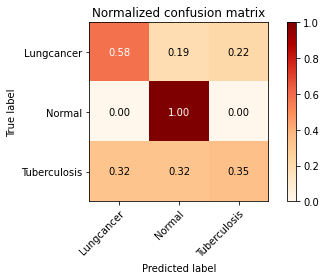

In [ ]:
y_pred = pred_model.argmax(axis=1)            ##
y_true  = y_test_Incep.argmax(axis=1)
y_test = y_test_Incep.argmax(axis=1)

class_names = le_Incep.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 32 soft pre bi   
0.637


In [ ]:
BS = 32
filepath = "model32_soft_pre_bi.h5"                  ##

train_img_Incep = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (299, 299))                                      
    train_img_Incep.append(img)
data_Incep = np.array(train_img_Incep, dtype="float32") / 255.0

labels_Incep = np.array(data_train3[['NameType']] )        
labels_Incep.shape = (len(labels_Incep),) 
le_Incep = LabelEncoder()                                                                     
labels_Incep = le_Incep.fit_transform(labels_Incep)                                         
labels_Incep = to_categorical(labels_Incep, num_classes=3)                   

aug = ImageDataGenerator( rotation_range=15,	width_shift_range=0.1, 	height_shift_range=0.1,
		shear_range=0.15, 	horizontal_flip=True, 	fill_mode="nearest")
                                                                                                           ## 
callback = EarlyStopping( monitor= "val_accuracy",    patience=15,       mode="max")

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
                                                                                                            ##
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,   patience=6,     verbose=1, mode='max', min_lr=0.00001)

(x_train_Incep, x_test_Incep, y_train_Incep, y_test_Incep ) = train_test_split(data_Incep, labels_Incep,
	                                                                                                test_size=0.25, random_state=40)

100%|██████████| 450/450 [00:05<00:00, 78.33it/s] 


In [ ]:
base_model_Incep = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3), include_top=False, weights="imagenet")
base_model_Incep.trainable = False


#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Incep.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Incep = tf.keras.models.Model(inputs=base_model_Incep.input, outputs=prediction_layer)

model_Incep.compile(optimizer=RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

H_Incep = model_Incep.fit( x=aug.flow(x_train_Incep, y_train_Incep, batch_size=BS),
	                                            validation_data=(x_test_Incep, y_test_Incep),
	                                            steps_per_epoch=len(x_train_Incep) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

pred_Incep = model_Incep.predict(x_test_Incep)

print(classification_report(y_test_Incep.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Incep.argmax(axis=1),  
                                        target_names=le_Incep.classes_))


Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 0.6714 - accuracy: 0.3279
Epoch 1: val_accuracy improved from -inf to 0.37168, saving model to model32_soft_pre_bi.h5
10/10 [==============================] - 16s 1s/step - loss: 0.6714 - accuracy: 0.3279 - val_loss: 0.6341 - val_accuracy: 0.3717 - lr: 1.0000e-04
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 0.6361 - accuracy: 0.3803
Epoch 2: val_accuracy did not improve from 0.37168
10/10 [==============================] - 8s 808ms/step - loss: 0.6361 - accuracy: 0.3803 - val_loss: 0.6275 - val_accuracy: 0.3451 - lr: 1.0000e-04
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.6309 - accuracy: 0.3967
Epoch 3: val_accuracy did not improve from 0.37168
10/10 [==============================] - 8s 801ms/step - loss: 0.6309 - accuracy: 0.3967 - val_loss: 0.6240 - val_accuracy: 0.3540 - lr: 1.0000e-04
Epoch 4/100
10/10 [==============================] - ETA: 0s - loss: 0.6263 - a

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

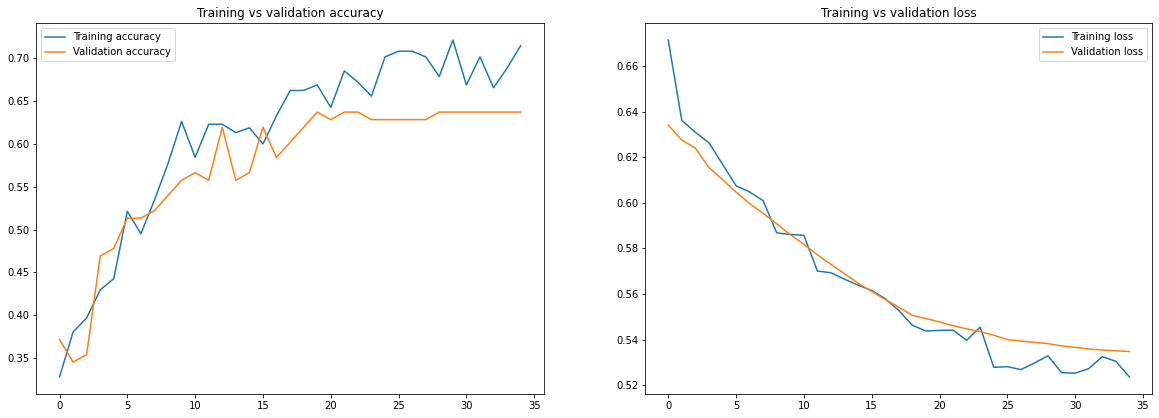

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H_Incep                            ##
pred_Dense = pred_Incep                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[20  7  9]
 [ 1 37  2]
 [12 10 15]]
Normalized confusion matrix
[[0.56 0.19 0.25]
 [0.03 0.93 0.05]
 [0.32 0.27 0.41]]


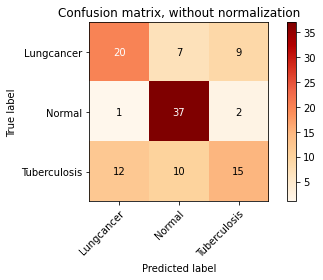

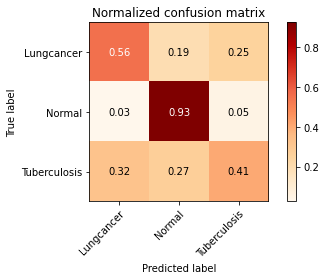

In [ ]:
y_pred = pred_Incep.argmax(axis=1)            ##
y_true  = y_test_Incep.argmax(axis=1)
y_test = y_test_Incep.argmax(axis=1)
class_names = le_Incep.classes_
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [ ]:
model = load_model(filepath)

In [ ]:
pred_model = model.predict(x_test_Incep)

print(classification_report(y_test_Incep.argmax(axis=1),   pred_model.argmax(axis=1), target_names=le_Incep.classes_))

              precision    recall  f1-score   support

  Lungcancer       0.58      0.58      0.58        36
      Normal       0.69      0.95      0.80        40
Tuberculosis       0.59      0.35      0.44        37

    accuracy                           0.64       113
   macro avg       0.62      0.63      0.61       113
weighted avg       0.62      0.64      0.61       113



Confusion matrix, without normalization
[[21  7  8]
 [ 1 38  1]
 [14 10 13]]
Normalized confusion matrix
[[0.58 0.19 0.22]
 [0.03 0.95 0.03]
 [0.38 0.27 0.35]]


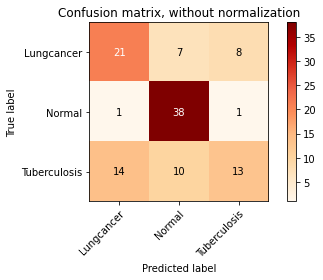

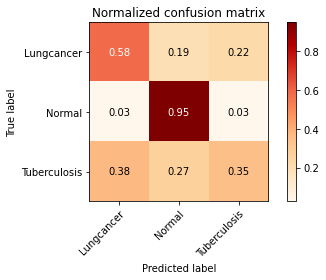

In [ ]:
y_pred = pred_model.argmax(axis=1)            ##
y_true  = y_test_Incep.argmax(axis=1)
y_test = y_test_Incep.argmax(axis=1)

class_names = le_Incep.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 32 soft pre bi  adam
0.655


In [ ]:
BS = 32
filepath = "model32_soft_pre_bi_adam.h5"                  ##

train_img_Incep = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (299, 299))                                      
    train_img_Incep.append(img)
data_Incep = np.array(train_img_Incep, dtype="float32") / 255.0

labels_Incep = np.array(data_train3[['NameType']] )        
labels_Incep.shape = (len(labels_Incep),) 
le_Incep = LabelEncoder()                                                                     
labels_Incep = le_Incep.fit_transform(labels_Incep)                                         
labels_Incep = to_categorical(labels_Incep, num_classes=3)                   

aug = ImageDataGenerator( rotation_range=15,	width_shift_range=0.1, 	height_shift_range=0.1,
		shear_range=0.15, 	horizontal_flip=True, 	fill_mode="nearest")
                                                                                                           ## 
callback = EarlyStopping( monitor= "val_accuracy",    patience=15,       mode="max")

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
                                                                                                            ##
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,   patience=6,     verbose=1, mode='max', min_lr=0.00001)

(x_train_Incep, x_test_Incep, y_train_Incep, y_test_Incep ) = train_test_split(data_Incep, labels_Incep,
	                                                                                                test_size=0.25, random_state=40)

100%|██████████| 450/450 [00:05<00:00, 82.50it/s] 


In [ ]:
base_model_Incep = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3), include_top=False, weights="imagenet")
base_model_Incep.trainable = False


#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Incep.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Incep = tf.keras.models.Model(inputs=base_model_Incep.input, outputs=prediction_layer)

model_Incep.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

H_Incep = model_Incep.fit( x=aug.flow(x_train_Incep, y_train_Incep, batch_size=BS),
	                                            validation_data=(x_test_Incep, y_test_Incep),
	                                            steps_per_epoch=len(x_train_Incep) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

pred_Incep = model_Incep.predict(x_test_Incep)

print(classification_report(y_test_Incep.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Incep.argmax(axis=1),  
                                        target_names=le_Incep.classes_))


Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 0.6898 - accuracy: 0.3213
Epoch 1: val_accuracy improved from -inf to 0.26549, saving model to model32_soft_pre_bi_adam.h5
10/10 [==============================] - 16s 1s/step - loss: 0.6898 - accuracy: 0.3213 - val_loss: 0.6604 - val_accuracy: 0.2655 - lr: 1.0000e-04
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 0.6513 - accuracy: 0.3562
Epoch 2: val_accuracy improved from 0.26549 to 0.35398, saving model to model32_soft_pre_bi_adam.h5
10/10 [==============================] - 9s 909ms/step - loss: 0.6513 - accuracy: 0.3562 - val_loss: 0.6456 - val_accuracy: 0.3540 - lr: 1.0000e-04
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.6373 - accuracy: 0.3672
Epoch 3: val_accuracy improved from 0.35398 to 0.37168, saving model to model32_soft_pre_bi_adam.h5
10/10 [==============================] - 9s 890ms/step - loss: 0.6373 - accuracy: 0.3672 - val_loss: 0.6407 - val_accuracy: 

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

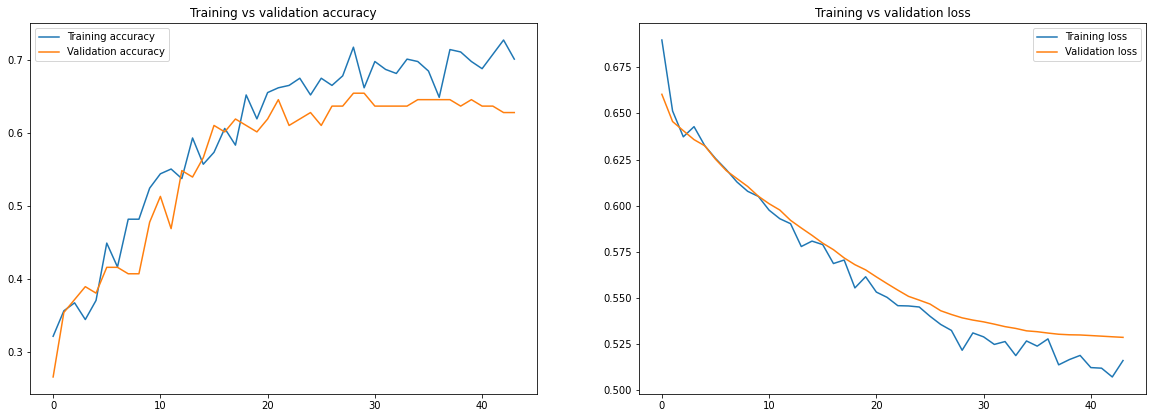

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H_Incep                            ##
pred_Dense = pred_Incep                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[18 10  8]
 [ 0 39  1]
 [11 12 14]]
Normalized confusion matrix
[[0.5  0.28 0.22]
 [0.   0.97 0.03]
 [0.3  0.32 0.38]]


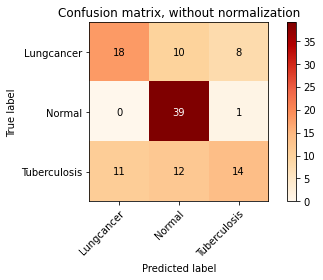

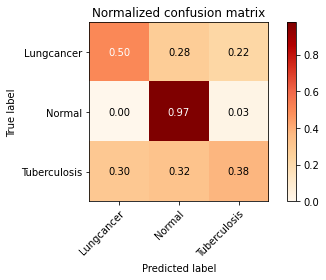

In [ ]:
y_pred = pred_Incep.argmax(axis=1)            ##
y_true  = y_test_Incep.argmax(axis=1)
y_test = y_test_Incep.argmax(axis=1)
class_names = le_Incep.classes_
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [ ]:
model = load_model(filepath)

In [ ]:
pred_model = model.predict(x_test_Incep)

print(classification_report(y_test_Incep.argmax(axis=1),   pred_model.argmax(axis=1), target_names=le_Incep.classes_))

              precision    recall  f1-score   support

  Lungcancer       0.66      0.58      0.62        36
      Normal       0.66      0.97      0.79        40
Tuberculosis       0.64      0.38      0.47        37

    accuracy                           0.65       113
   macro avg       0.65      0.65      0.63       113
weighted avg       0.65      0.65      0.63       113



Confusion matrix, without normalization
[[21  8  7]
 [ 0 39  1]
 [11 12 14]]
Normalized confusion matrix
[[0.58 0.22 0.19]
 [0.   0.97 0.03]
 [0.3  0.32 0.38]]


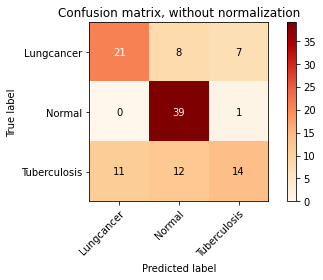

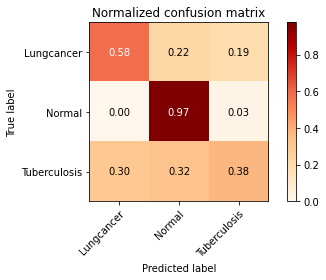

In [ ]:
y_pred = pred_model.argmax(axis=1)            ##
y_true  = y_test_Incep.argmax(axis=1)
y_test = y_test_Incep.argmax(axis=1)

class_names = le_Incep.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# 0-100   

#### 16 soft fine cate 
0.85


In [12]:
BS = 16
filepath = "model16_soft_fine_cate.h5"                  ##

train_img_Incep = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (299, 299))                                      
    train_img_Incep.append(img)
data_Incep = np.array(train_img_Incep, dtype="float32") / 255.0

labels_Incep = np.array(data_train3[['NameType']] )        
labels_Incep.shape = (len(labels_Incep),) 
le_Incep = LabelEncoder()                                                                     
labels_Incep = le_Incep.fit_transform(labels_Incep)                                         
labels_Incep = to_categorical(labels_Incep, num_classes=3)                   

aug = ImageDataGenerator( rotation_range=15,	width_shift_range=0.1, 	height_shift_range=0.1,
		shear_range=0.15, 	horizontal_flip=True, 	fill_mode="nearest")
                                                                                                           ## 
callback = EarlyStopping( monitor= "val_accuracy",    patience=15,       mode="max")

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
                                                                                                            ##
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,   patience=6,     verbose=1, mode='max', min_lr=0.00001)

(x_train_Incep, x_test_Incep, y_train_Incep, y_test_Incep ) = train_test_split(data_Incep, labels_Incep,
	                                                                                                test_size=0.25, random_state=40)

100%|██████████| 450/450 [00:07<00:00, 57.39it/s]


In [13]:
base_model_Incep = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3), include_top=False, weights="imagenet")
len(base_model_Incep.layers)

base_model_Incep.trainable = True
for layer in base_model_Incep.layers[:100]:    #fix w & bias in layer 0-100
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Incep.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Incep = tf.keras.models.Model(inputs=base_model_Incep.input, outputs=prediction_layer)

model_Incep.compile(optimizer=RMSprop(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

H_Incep = model_Incep.fit( x=aug.flow(x_train_Incep, y_train_Incep, batch_size=BS),
	                                            validation_data=(x_test_Incep, y_test_Incep),
	                                            steps_per_epoch=len(x_train_Incep) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

pred_Incep = model_Incep.predict(x_test_Incep)

print(classification_report(y_test_Incep.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Incep.argmax(axis=1),  
                                        target_names=le_Incep.classes_))


87924736/87910968 [==============================] - 1s 0us/step
Epoch 1/100
21/21 [==============================] - ETA: 0s - loss: 0.8284 - accuracy: 0.5950
Epoch 1: val_accuracy improved from -inf to 0.50442, saving model to model16_soft_fine_cate.h5
21/21 [==============================] - 63s 1s/step - loss: 0.8284 - accuracy: 0.5950 - val_loss: 1.0052 - val_accuracy: 0.5044 - lr: 1.0000e-04
Epoch 2/100
21/21 [==============================] - ETA: 0s - loss: 0.5140 - accuracy: 0.7887
Epoch 2: val_accuracy did not improve from 0.50442
21/21 [==============================] - 11s 489ms/step - loss: 0.5140 - accuracy: 0.7887 - val_loss: 2.1460 - val_accuracy: 0.4071 - lr: 1.0000e-04
Epoch 3/100
21/21 [==============================] - ETA: 0s - loss: 0.3773 - accuracy: 0.8598
Epoch 3: val_accuracy improved from 0.50442 to 0.51327, saving model to model16_soft_fine_cate.h5
21/21 [==============================] - 11s 536ms/step - loss: 0.3773 - accuracy: 0.8598 - val_loss: 2.0137 - 

In [14]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

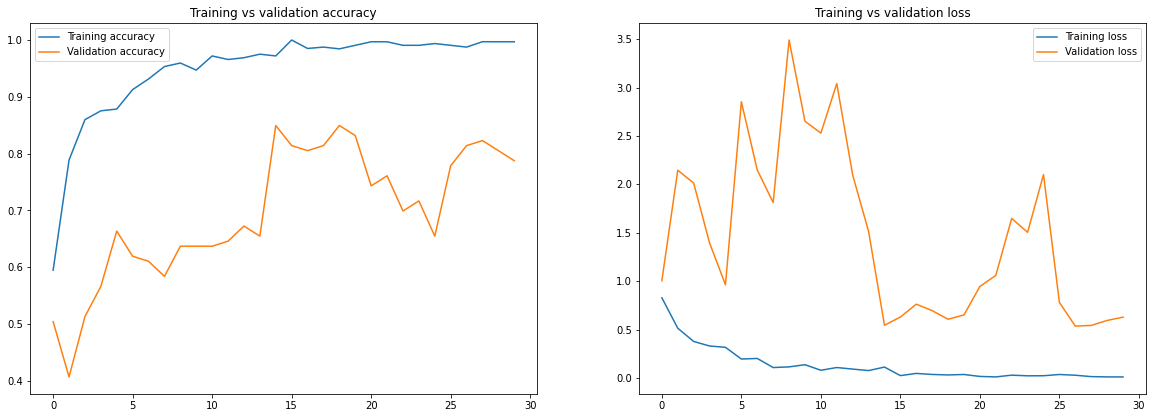

<Figure size 432x288 with 0 Axes>

In [15]:
H_Dense = H_Incep                            ##
pred_Dense = pred_Incep                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[19  0 17]
 [ 0 39  1]
 [ 3  3 31]]
Normalized confusion matrix
[[0.53 0.   0.47]
 [0.   0.97 0.03]
 [0.08 0.08 0.84]]


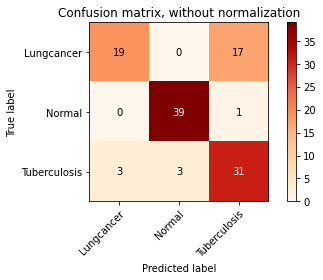

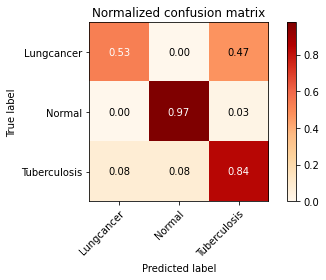

In [16]:
y_pred = pred_Incep.argmax(axis=1)            ##
y_true  = y_test_Incep.argmax(axis=1)
y_test = y_test_Incep.argmax(axis=1)
class_names = le_Incep.classes_
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [17]:
model = load_model(filepath)

In [18]:
pred_model = model.predict(x_test_Incep)

print(classification_report(y_test_Incep.argmax(axis=1),   pred_model.argmax(axis=1), target_names=le_Incep.classes_))

              precision    recall  f1-score   support

  Lungcancer       0.93      0.69      0.79        36
      Normal       0.93      0.97      0.95        40
Tuberculosis       0.73      0.86      0.79        37

    accuracy                           0.85       113
   macro avg       0.86      0.84      0.84       113
weighted avg       0.86      0.85      0.85       113



Confusion matrix, without normalization
[[25  0 11]
 [ 0 39  1]
 [ 2  3 32]]
Normalized confusion matrix
[[0.69 0.   0.31]
 [0.   0.97 0.03]
 [0.05 0.08 0.86]]


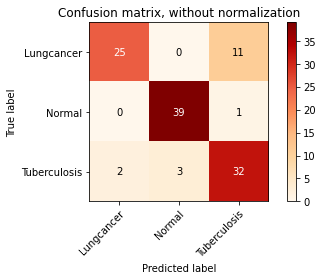

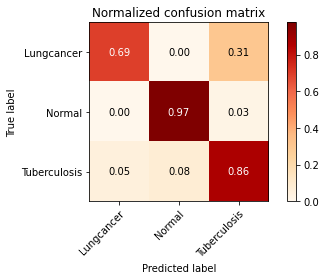

In [19]:
y_pred = pred_model.argmax(axis=1)            ##
y_true  = y_test_Incep.argmax(axis=1)
y_test = y_test_Incep.argmax(axis=1)

class_names = le_Incep.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 8 soft fine cate
0.88


In [20]:
BS = 8
filepath = "model8_soft_fine_cate.h5"                  ##

train_img_Incep = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (299, 299))                                      
    train_img_Incep.append(img)
data_Incep = np.array(train_img_Incep, dtype="float32") / 255.0

labels_Incep = np.array(data_train3[['NameType']] )        
labels_Incep.shape = (len(labels_Incep),) 
le_Incep = LabelEncoder()                                                                     
labels_Incep = le_Incep.fit_transform(labels_Incep)                                         
labels_Incep = to_categorical(labels_Incep, num_classes=3)                   

aug = ImageDataGenerator( rotation_range=15,	width_shift_range=0.1, 	height_shift_range=0.1,
		shear_range=0.15, 	horizontal_flip=True, 	fill_mode="nearest")
                                                                                                           ## 
callback = EarlyStopping( monitor= "val_accuracy",    patience=15,       mode="max")

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
                                                                                                            ##
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,   patience=6,     verbose=1, mode='max', min_lr=0.00001)

(x_train_Incep, x_test_Incep, y_train_Incep, y_test_Incep ) = train_test_split(data_Incep, labels_Incep,
	                                                                                                test_size=0.25, random_state=40)

100%|██████████| 450/450 [00:05<00:00, 79.33it/s] 


In [21]:
base_model_Incep = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3), include_top=False, weights="imagenet")
len(base_model_Incep.layers)

base_model_Incep.trainable = True
for layer in base_model_Incep.layers[:100]:    #fix w & bias in layer 0-100
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Incep.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Incep = tf.keras.models.Model(inputs=base_model_Incep.input, outputs=prediction_layer)

model_Incep.compile(optimizer=RMSprop(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

H_Incep = model_Incep.fit( x=aug.flow(x_train_Incep, y_train_Incep, batch_size=BS),
	                                            validation_data=(x_test_Incep, y_test_Incep),
	                                            steps_per_epoch=len(x_train_Incep) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

pred_Incep = model_Incep.predict(x_test_Incep)

print(classification_report(y_test_Incep.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Incep.argmax(axis=1),  
                                        target_names=le_Incep.classes_))


Epoch 1/100
42/42 [==============================] - ETA: 0s - loss: 0.7981 - accuracy: 0.6170
Epoch 1: val_accuracy improved from -inf to 0.37168, saving model to model8_soft_fine_cate.h5
42/42 [==============================] - 27s 320ms/step - loss: 0.7981 - accuracy: 0.6170 - val_loss: 1.9290 - val_accuracy: 0.3717 - lr: 1.0000e-04
Epoch 2/100
42/42 [==============================] - ETA: 0s - loss: 0.6165 - accuracy: 0.7477
Epoch 2: val_accuracy improved from 0.37168 to 0.43363, saving model to model8_soft_fine_cate.h5
42/42 [==============================] - 12s 284ms/step - loss: 0.6165 - accuracy: 0.7477 - val_loss: 1.8122 - val_accuracy: 0.4336 - lr: 1.0000e-04
Epoch 3/100
42/42 [==============================] - ETA: 0s - loss: 0.4538 - accuracy: 0.8207
Epoch 3: val_accuracy improved from 0.43363 to 0.48673, saving model to model8_soft_fine_cate.h5
42/42 [==============================] - 12s 283ms/step - loss: 0.4538 - accuracy: 0.8207 - val_loss: 1.9742 - val_accuracy: 0.48

In [22]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

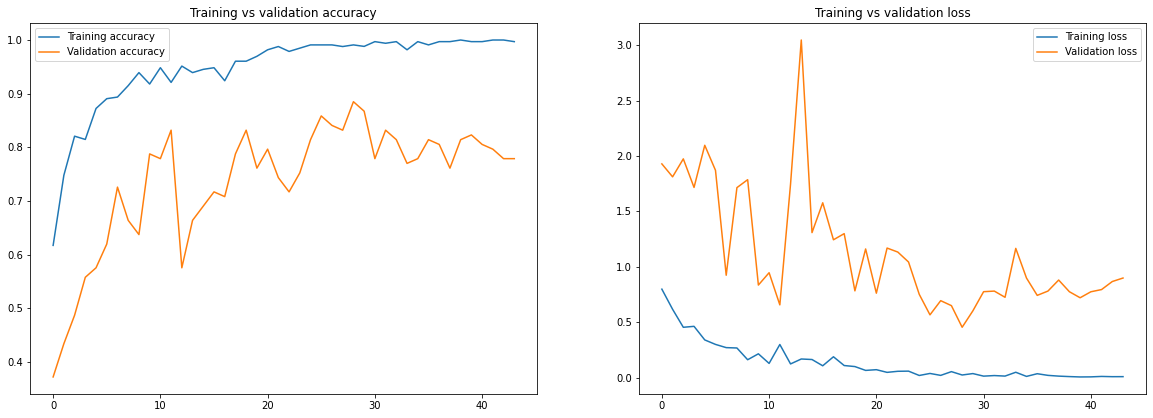

<Figure size 432x288 with 0 Axes>

In [23]:
H_Dense = H_Incep                            ##
pred_Dense = pred_Incep                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[16  0 20]
 [ 0 38  2]
 [ 1  2 34]]
Normalized confusion matrix
[[0.44 0.   0.56]
 [0.   0.95 0.05]
 [0.03 0.05 0.92]]


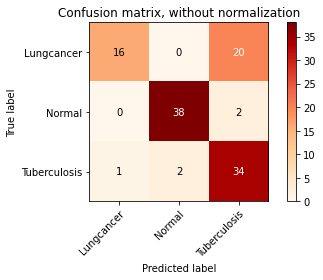

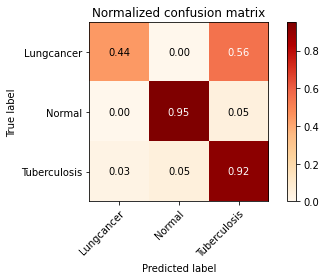

In [24]:
y_pred = pred_Incep.argmax(axis=1)            ##
y_true  = y_test_Incep.argmax(axis=1)
y_test = y_test_Incep.argmax(axis=1)
class_names = le_Incep.classes_
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [25]:
model = load_model(filepath)

In [26]:
pred_model = model.predict(x_test_Incep)

print(classification_report(y_test_Incep.argmax(axis=1),   pred_model.argmax(axis=1), target_names=le_Incep.classes_))

              precision    recall  f1-score   support

  Lungcancer       0.96      0.75      0.84        36
      Normal       0.93      1.00      0.96        40
Tuberculosis       0.79      0.89      0.84        37

    accuracy                           0.88       113
   macro avg       0.89      0.88      0.88       113
weighted avg       0.89      0.88      0.88       113



Confusion matrix, without normalization
[[27  0  9]
 [ 0 40  0]
 [ 1  3 33]]
Normalized confusion matrix
[[0.75 0.   0.25]
 [0.   1.   0.  ]
 [0.03 0.08 0.89]]


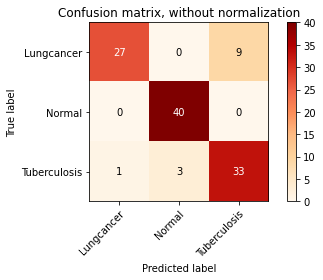

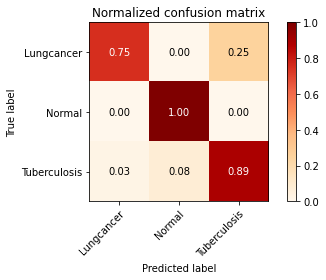

In [27]:
y_pred = pred_model.argmax(axis=1)            ##
y_true  = y_test_Incep.argmax(axis=1)
y_test = y_test_Incep.argmax(axis=1)

class_names = le_Incep.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 32 soft fine cate adam
0.


In [28]:
BS = 32
filepath = "model32_soft_fine_cate_adam.h5"                  ##

train_img_Incep = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (299, 299))                                      
    train_img_Incep.append(img)
data_Incep = np.array(train_img_Incep, dtype="float32") / 255.0

labels_Incep = np.array(data_train3[['NameType']] )        
labels_Incep.shape = (len(labels_Incep),) 
le_Incep = LabelEncoder()                                                                     
labels_Incep = le_Incep.fit_transform(labels_Incep)                                         
labels_Incep = to_categorical(labels_Incep, num_classes=3)                   

aug = ImageDataGenerator( rotation_range=15,	width_shift_range=0.1, 	height_shift_range=0.1,
		shear_range=0.15, 	horizontal_flip=True, 	fill_mode="nearest")
                                                                                                           ## 
callback = EarlyStopping( monitor= "val_accuracy",    patience=15,       mode="max")

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
                                                                                                            ##
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,   patience=6,     verbose=1, mode='max', min_lr=0.00001)

(x_train_Incep, x_test_Incep, y_train_Incep, y_test_Incep ) = train_test_split(data_Incep, labels_Incep,
	                                                                                                test_size=0.25, random_state=40)

100%|██████████| 450/450 [00:05<00:00, 76.39it/s] 


In [29]:
base_model_Incep = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3), include_top=False, weights="imagenet")
len(base_model_Incep.layers)

base_model_Incep.trainable = True
for layer in base_model_Incep.layers[:100]:    #fix w & bias in layer 0-100
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Incep.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Incep = tf.keras.models.Model(inputs=base_model_Incep.input, outputs=prediction_layer)

model_Incep.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

H_Incep = model_Incep.fit( x=aug.flow(x_train_Incep, y_train_Incep, batch_size=BS),
	                                            validation_data=(x_test_Incep, y_test_Incep),
	                                            steps_per_epoch=len(x_train_Incep) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

pred_Incep = model_Incep.predict(x_test_Incep)

print(classification_report(y_test_Incep.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Incep.argmax(axis=1),  
                                        target_names=le_Incep.classes_))


Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 0.9041 - accuracy: 0.5672
Epoch 1: val_accuracy improved from -inf to 0.44248, saving model to model32_soft_fine_cate_adam.h5
10/10 [==============================] - 23s 1s/step - loss: 0.9041 - accuracy: 0.5672 - val_loss: 1.1499 - val_accuracy: 0.4425 - lr: 1.0000e-04
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 0.5194 - accuracy: 0.7246
Epoch 2: val_accuracy improved from 0.44248 to 0.54867, saving model to model32_soft_fine_cate_adam.h5
10/10 [==============================] - 11s 1s/step - loss: 0.5194 - accuracy: 0.7246 - val_loss: 0.9381 - val_accuracy: 0.5487 - lr: 1.0000e-04
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.3896 - accuracy: 0.8557
Epoch 3: val_accuracy improved from 0.54867 to 0.58407, saving model to model32_soft_fine_cate_adam.h5
10/10 [==============================] - 11s 1s/step - loss: 0.3896 - accuracy: 0.8557 - val_loss: 1.1238 - val_accur

In [30]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

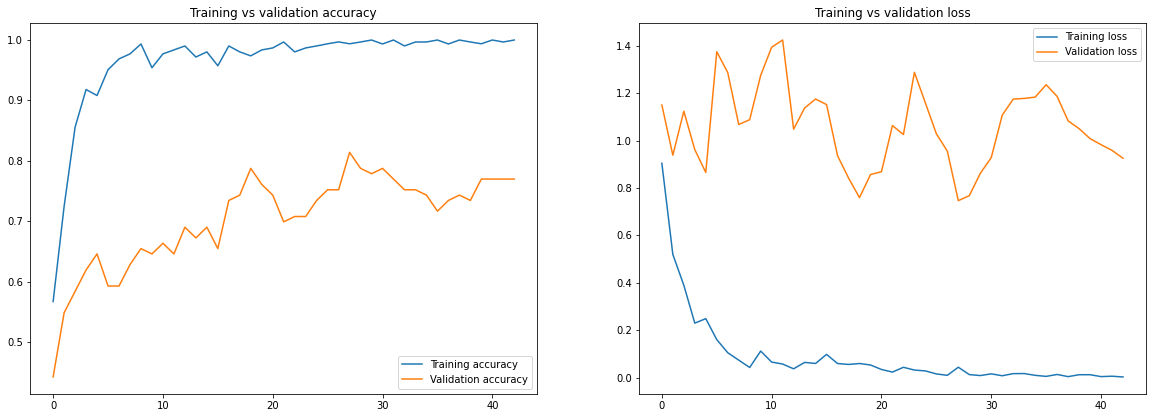

<Figure size 432x288 with 0 Axes>

In [31]:
H_Dense = H_Incep                            ##
pred_Dense = pred_Incep                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[15  2 19]
 [ 0 40  0]
 [ 1  4 32]]
Normalized confusion matrix
[[0.42 0.06 0.53]
 [0.   1.   0.  ]
 [0.03 0.11 0.86]]


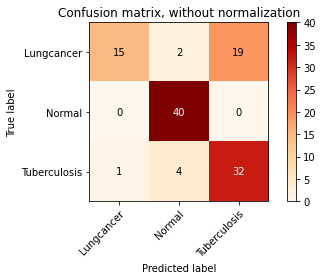

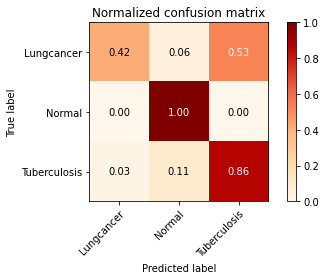

In [32]:
y_pred = pred_Incep.argmax(axis=1)            ##
y_true  = y_test_Incep.argmax(axis=1)
y_test = y_test_Incep.argmax(axis=1)
class_names = le_Incep.classes_
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [33]:
model = load_model(filepath)

In [34]:
pred_model = model.predict(x_test_Incep)

print(classification_report(y_test_Incep.argmax(axis=1),   pred_model.argmax(axis=1), target_names=le_Incep.classes_))

              precision    recall  f1-score   support

  Lungcancer       0.95      0.53      0.68        36
      Normal       0.89      1.00      0.94        40
Tuberculosis       0.69      0.89      0.78        37

    accuracy                           0.81       113
   macro avg       0.84      0.81      0.80       113
weighted avg       0.84      0.81      0.80       113



Confusion matrix, without normalization
[[19  2 15]
 [ 0 40  0]
 [ 1  3 33]]
Normalized confusion matrix
[[0.53 0.06 0.42]
 [0.   1.   0.  ]
 [0.03 0.08 0.89]]


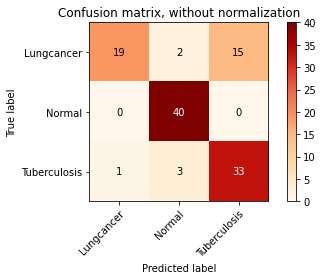

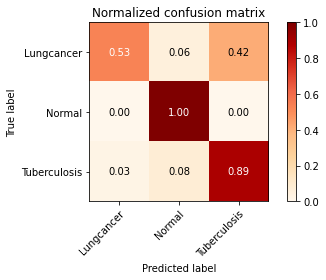

In [35]:
y_pred = pred_model.argmax(axis=1)            ##
y_true  = y_test_Incep.argmax(axis=1)
y_test = y_test_Incep.argmax(axis=1)

class_names = le_Incep.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 1 soft fine bi 
0.761


In [ ]:
BS = 1
filepath = "model1_soft_fine_bi.h5"                  ##

train_img_Incep = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (299, 299))                                      
    train_img_Incep.append(img)
data_Incep = np.array(train_img_Incep, dtype="float32") / 255.0

labels_Incep = np.array(data_train3[['NameType']] )        
labels_Incep.shape = (len(labels_Incep),) 
le_Incep = LabelEncoder()                                                                     
labels_Incep = le_Incep.fit_transform(labels_Incep)                                         
labels_Incep = to_categorical(labels_Incep, num_classes=3)                   

aug = ImageDataGenerator( rotation_range=15,	width_shift_range=0.1, 	height_shift_range=0.1,
		shear_range=0.15, 	horizontal_flip=True, 	fill_mode="nearest")
                                                                                                           ## 
callback = EarlyStopping( monitor= "val_accuracy",    patience=15,       mode="max")

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
                                                                                                            ##
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,   patience=6,     verbose=1, mode='max', min_lr=0.00001)

(x_train_Incep, x_test_Incep, y_train_Incep, y_test_Incep ) = train_test_split(data_Incep, labels_Incep,
	                                                                                                test_size=0.25, random_state=40)

100%|██████████| 450/450 [00:04<00:00, 108.55it/s]


In [ ]:
base_model_Incep = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3), include_top=False, weights="imagenet")
len(base_model_Incep.layers)

base_model_Incep.trainable = True
for layer in base_model_Incep.layers[:100]:    #fix w & bias in layer 0-100
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Incep.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Incep = tf.keras.models.Model(inputs=base_model_Incep.input, outputs=prediction_layer)

model_Incep.compile(optimizer=RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

H_Incep = model_Incep.fit( x=aug.flow(x_train_Incep, y_train_Incep, batch_size=BS),
	                                            validation_data=(x_test_Incep, y_test_Incep),
	                                            steps_per_epoch=len(x_train_Incep) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

pred_Incep = model_Incep.predict(x_test_Incep)

print(classification_report(y_test_Incep.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Incep.argmax(axis=1),  
                                        target_names=le_Incep.classes_))


Epoch 1/100
336/337 [============================>.] - ETA: 0s - loss: 0.6272 - accuracy: 0.4196
Epoch 1: val_accuracy improved from -inf to 0.47788, saving model to model1_soft_fine_bi.h5
337/337 [==============================] - 26s 52ms/step - loss: 0.6267 - accuracy: 0.4214 - val_loss: 0.6618 - val_accuracy: 0.4779 - lr: 1.0000e-04
Epoch 2/100
336/337 [============================>.] - ETA: 0s - loss: 0.4921 - accuracy: 0.5774
Epoch 2: val_accuracy improved from 0.47788 to 0.63717, saving model to model1_soft_fine_bi.h5
337/337 [==============================] - 16s 48ms/step - loss: 0.4920 - accuracy: 0.5786 - val_loss: 0.5786 - val_accuracy: 0.6372 - lr: 1.0000e-04
Epoch 3/100
336/337 [============================>.] - ETA: 0s - loss: 0.4289 - accuracy: 0.6369
Epoch 3: val_accuracy improved from 0.63717 to 0.64602, saving model to model1_soft_fine_bi.h5
337/337 [==============================] - 16s 49ms/step - loss: 0.4294 - accuracy: 0.6350 - val_loss: 1.1844 - val_accuracy: 0

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

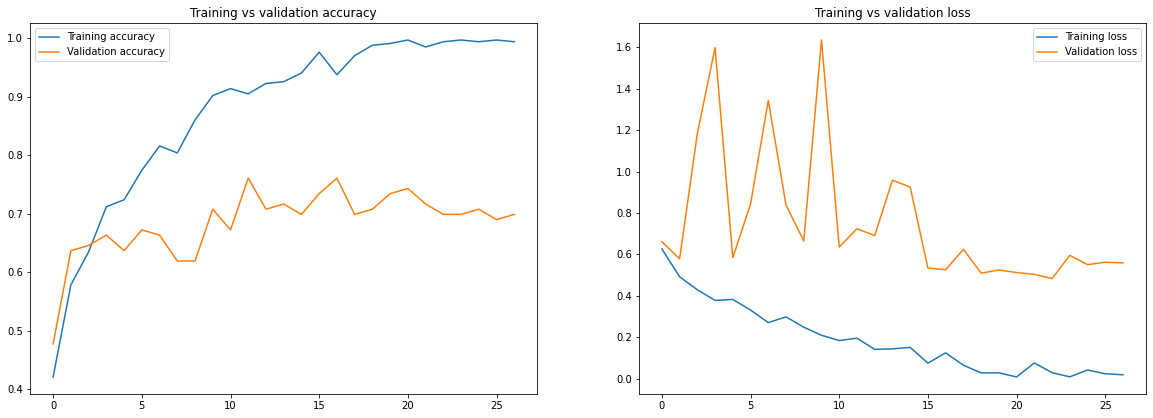

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H_Incep                            ##
pred_Dense = pred_Incep                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[17  1 18]
 [ 0 38  2]
 [10  3 24]]
Normalized confusion matrix
[[0.47 0.03 0.5 ]
 [0.   0.95 0.05]
 [0.27 0.08 0.65]]


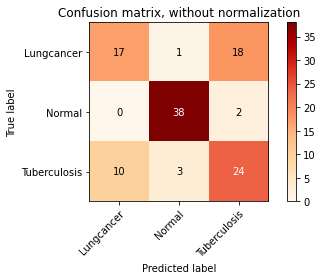

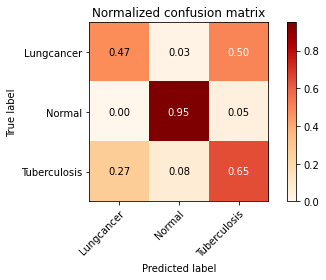

In [ ]:
y_pred = pred_Incep.argmax(axis=1)            ##
y_true  = y_test_Incep.argmax(axis=1)
y_test = y_test_Incep.argmax(axis=1)
class_names = le_Incep.classes_
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [ ]:
model = load_model(filepath)

In [ ]:
pred_model = model.predict(x_test_Incep)

print(classification_report(y_test_Incep.argmax(axis=1),   pred_model.argmax(axis=1), target_names=le_Incep.classes_))

              precision    recall  f1-score   support

  Lungcancer       0.65      0.72      0.68        36
      Normal       0.91      0.97      0.94        40
Tuberculosis       0.70      0.57      0.63        37

    accuracy                           0.76       113
   macro avg       0.75      0.75      0.75       113
weighted avg       0.76      0.76      0.76       113



Confusion matrix, without normalization
[[26  1  9]
 [ 1 39  0]
 [13  3 21]]
Normalized confusion matrix
[[0.72 0.03 0.25]
 [0.03 0.97 0.  ]
 [0.35 0.08 0.57]]


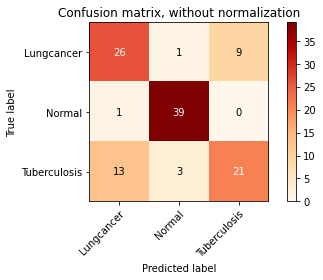

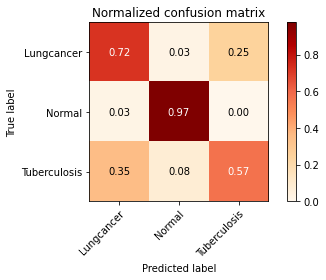

In [ ]:
y_pred = pred_model.argmax(axis=1)            ##
y_true  = y_test_Incep.argmax(axis=1)
y_test = y_test_Incep.argmax(axis=1)

class_names = le_Incep.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 1 soft fine bi adam
0.726


In [ ]:
BS = 1
filepath = "model1_soft_fine_bi_adam.h5"                  ##

train_img_Incep = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (299, 299))                                      
    train_img_Incep.append(img)
data_Incep = np.array(train_img_Incep, dtype="float32") / 255.0

labels_Incep = np.array(data_train3[['NameType']] )        
labels_Incep.shape = (len(labels_Incep),) 
le_Incep = LabelEncoder()                                                                     
labels_Incep = le_Incep.fit_transform(labels_Incep)                                         
labels_Incep = to_categorical(labels_Incep, num_classes=3)                   

aug = ImageDataGenerator( rotation_range=15,	width_shift_range=0.1, 	height_shift_range=0.1,
		shear_range=0.15, 	horizontal_flip=True, 	fill_mode="nearest")
                                                                                                           ## 
callback = EarlyStopping( monitor= "val_accuracy",    patience=15,       mode="max")

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
                                                                                                            ##
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,   patience=6,     verbose=1, mode='max', min_lr=0.00001)

(x_train_Incep, x_test_Incep, y_train_Incep, y_test_Incep ) = train_test_split(data_Incep, labels_Incep,
	                                                                                                test_size=0.25, random_state=40)

100%|██████████| 450/450 [00:04<00:00, 106.95it/s]


In [ ]:
base_model_Incep = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3), include_top=False, weights="imagenet")
len(base_model_Incep.layers)

base_model_Incep.trainable = True
for layer in base_model_Incep.layers[:100]:    #fix w & bias in layer 0-100
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Incep.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Incep = tf.keras.models.Model(inputs=base_model_Incep.input, outputs=prediction_layer)

model_Incep.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

H_Incep = model_Incep.fit( x=aug.flow(x_train_Incep, y_train_Incep, batch_size=BS),
	                                            validation_data=(x_test_Incep, y_test_Incep),
	                                            steps_per_epoch=len(x_train_Incep) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

pred_Incep = model_Incep.predict(x_test_Incep)

print(classification_report(y_test_Incep.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Incep.argmax(axis=1),  
                                        target_names=le_Incep.classes_))


Epoch 1/100
336/337 [============================>.] - ETA: 0s - loss: 0.6175 - accuracy: 0.4345
Epoch 1: val_accuracy improved from -inf to 0.47788, saving model to model1_soft_fine_bi_adam.h5
337/337 [==============================] - 21s 46ms/step - loss: 0.6165 - accuracy: 0.4362 - val_loss: 0.5903 - val_accuracy: 0.4779 - lr: 1.0000e-04
Epoch 2/100
337/337 [==============================] - ETA: 0s - loss: 0.4716 - accuracy: 0.5816
Epoch 2: val_accuracy improved from 0.47788 to 0.50442, saving model to model1_soft_fine_bi_adam.h5
337/337 [==============================] - 14s 43ms/step - loss: 0.4716 - accuracy: 0.5816 - val_loss: 0.5725 - val_accuracy: 0.5044 - lr: 1.0000e-04
Epoch 3/100
336/337 [============================>.] - ETA: 0s - loss: 0.4503 - accuracy: 0.6101
Epoch 3: val_accuracy improved from 0.50442 to 0.51327, saving model to model1_soft_fine_bi_adam.h5
337/337 [==============================] - 15s 43ms/step - loss: 0.4493 - accuracy: 0.6113 - val_loss: 0.6444 - 

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

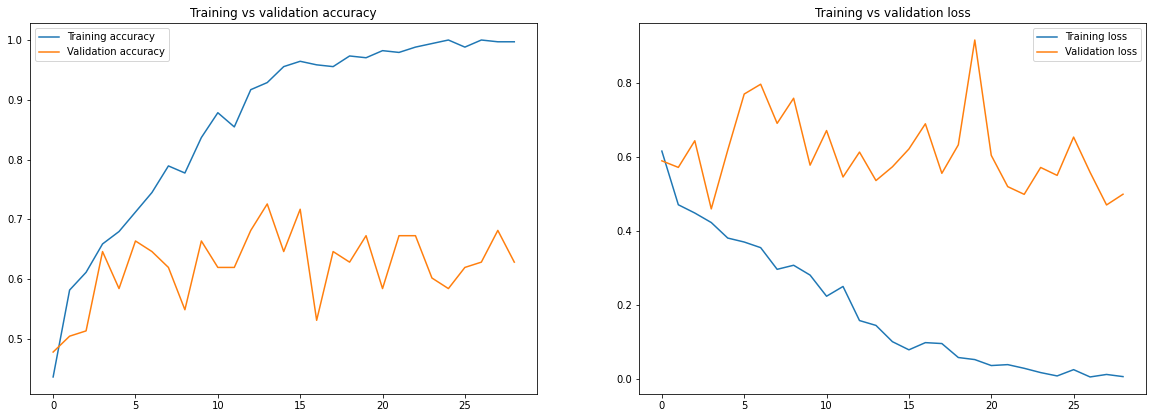

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H_Incep                            ##
pred_Dense = pred_Incep                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[30  3  3]
 [ 9 28  3]
 [20  4 13]]
Normalized confusion matrix
[[0.83 0.08 0.08]
 [0.23 0.7  0.07]
 [0.54 0.11 0.35]]


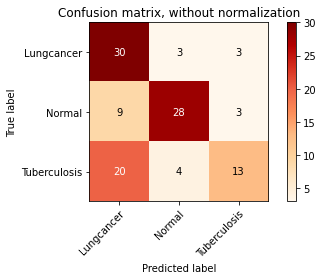

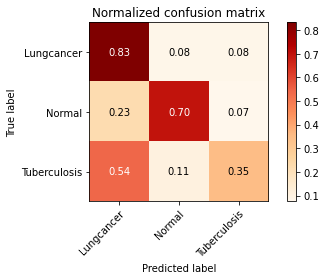

In [ ]:
y_pred = pred_Incep.argmax(axis=1)            ##
y_true  = y_test_Incep.argmax(axis=1)
y_test = y_test_Incep.argmax(axis=1)
class_names = le_Incep.classes_
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [ ]:
model = load_model(filepath)

In [ ]:
pred_model = model.predict(x_test_Incep)

print(classification_report(y_test_Incep.argmax(axis=1),   pred_model.argmax(axis=1), target_names=le_Incep.classes_))

              precision    recall  f1-score   support

  Lungcancer       0.65      0.92      0.76        36
      Normal       0.82      0.90      0.86        40
Tuberculosis       0.72      0.35      0.47        37

    accuracy                           0.73       113
   macro avg       0.73      0.72      0.70       113
weighted avg       0.73      0.73      0.70       113



Confusion matrix, without normalization
[[33  1  2]
 [ 1 36  3]
 [17  7 13]]
Normalized confusion matrix
[[0.92 0.03 0.06]
 [0.03 0.9  0.07]
 [0.46 0.19 0.35]]


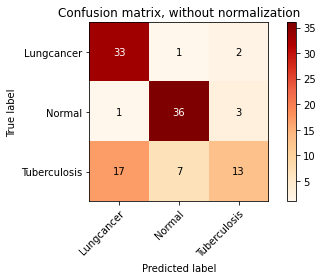

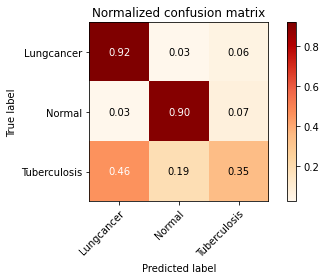

In [ ]:
y_pred = pred_model.argmax(axis=1)            ##
y_true  = y_test_Incep.argmax(axis=1)
y_test = y_test_Incep.argmax(axis=1)

class_names = le_Incep.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 8 soft fine bi 
0.832


In [ ]:
BS = 8
filepath = "model8_soft_fine_bi.h5"                  ##

train_img_Incep = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (299, 299))                                      
    train_img_Incep.append(img)
data_Incep = np.array(train_img_Incep, dtype="float32") / 255.0

labels_Incep = np.array(data_train3[['NameType']] )        
labels_Incep.shape = (len(labels_Incep),) 
le_Incep = LabelEncoder()                                                                     
labels_Incep = le_Incep.fit_transform(labels_Incep)                                         
labels_Incep = to_categorical(labels_Incep, num_classes=3)                   

aug = ImageDataGenerator( rotation_range=15,	width_shift_range=0.1, 	height_shift_range=0.1,
		shear_range=0.15, 	horizontal_flip=True, 	fill_mode="nearest")
                                                                                                           ## 
callback = EarlyStopping( monitor= "val_accuracy",    patience=15,       mode="max")

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
                                                                                                            ##
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,   patience=6,     verbose=1, mode='max', min_lr=0.00001)

(x_train_Incep, x_test_Incep, y_train_Incep, y_test_Incep ) = train_test_split(data_Incep, labels_Incep,
	                                                                                                test_size=0.25, random_state=40)

100%|██████████| 450/450 [02:21<00:00,  3.17it/s]


In [ ]:
base_model_Incep = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3), include_top=False, weights="imagenet")
len(base_model_Incep.layers)

base_model_Incep.trainable = True
for layer in base_model_Incep.layers[:100]:    #fix w & bias in layer 0-100
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Incep.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Incep = tf.keras.models.Model(inputs=base_model_Incep.input, outputs=prediction_layer)

model_Incep.compile(optimizer=RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

H_Incep = model_Incep.fit( x=aug.flow(x_train_Incep, y_train_Incep, batch_size=BS),
	                                            validation_data=(x_test_Incep, y_test_Incep),
	                                            steps_per_epoch=len(x_train_Incep) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

pred_Incep = model_Incep.predict(x_test_Incep)

print(classification_report(y_test_Incep.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Incep.argmax(axis=1),  
                                        target_names=le_Incep.classes_))


Epoch 1/100
42/42 [==============================] - ETA: 0s - loss: 0.4966 - accuracy: 0.6079
Epoch 1: val_accuracy improved from -inf to 0.45133, saving model to model8_soft_fine_bi.h5
42/42 [==============================] - 35s 360ms/step - loss: 0.4966 - accuracy: 0.6079 - val_loss: 0.7037 - val_accuracy: 0.4513 - lr: 1.0000e-04
Epoch 2/100
42/42 [==============================] - ETA: 0s - loss: 0.3182 - accuracy: 0.8359
Epoch 2: val_accuracy improved from 0.45133 to 0.67257, saving model to model8_soft_fine_bi.h5
42/42 [==============================] - 9s 205ms/step - loss: 0.3182 - accuracy: 0.8359 - val_loss: 0.5524 - val_accuracy: 0.6726 - lr: 1.0000e-04
Epoch 3/100
42/42 [==============================] - ETA: 0s - loss: 0.2683 - accuracy: 0.8419
Epoch 3: val_accuracy improved from 0.67257 to 0.80531, saving model to model8_soft_fine_bi.h5
42/42 [==============================] - 8s 199ms/step - loss: 0.2683 - accuracy: 0.8419 - val_loss: 0.2915 - val_accuracy: 0.8053 - lr:

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

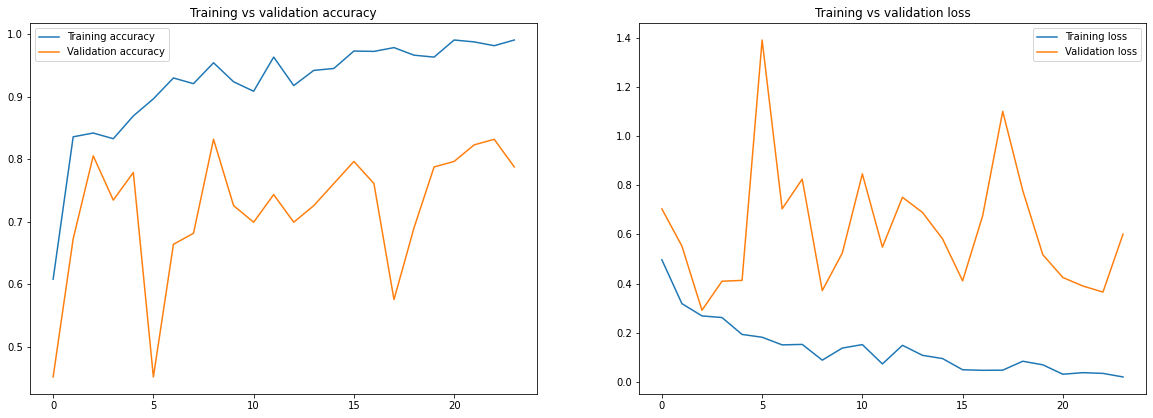

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H_Incep                            ##
pred_Dense = pred_Incep                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[16  0 20]
 [ 0 39  1]
 [ 2  1 34]]
Normalized confusion matrix
[[0.44 0.   0.56]
 [0.   0.97 0.03]
 [0.05 0.03 0.92]]


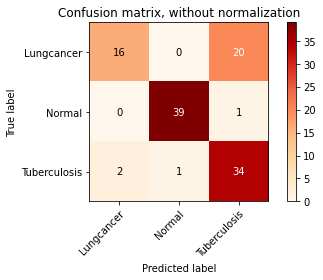

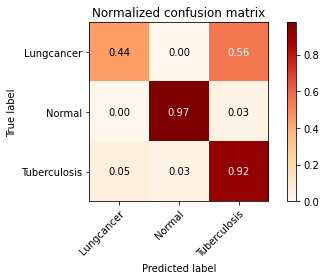

In [ ]:
y_pred = pred_Incep.argmax(axis=1)            ##
y_true  = y_test_Incep.argmax(axis=1)
y_test = y_test_Incep.argmax(axis=1)
class_names = le_Incep.classes_
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [ ]:
model = load_model(filepath)

In [ ]:
pred_model = model.predict(x_test_Incep)

print(classification_report(y_test_Incep.argmax(axis=1),   pred_model.argmax(axis=1), target_names=le_Incep.classes_))

              precision    recall  f1-score   support

  Lungcancer       0.89      0.69      0.78        36
      Normal       0.97      0.90      0.94        40
Tuberculosis       0.69      0.89      0.78        37

    accuracy                           0.83       113
   macro avg       0.85      0.83      0.83       113
weighted avg       0.85      0.83      0.83       113



Confusion matrix, without normalization
[[25  0 11]
 [ 0 36  4]
 [ 3  1 33]]
Normalized confusion matrix
[[0.69 0.   0.31]
 [0.   0.9  0.1 ]
 [0.08 0.03 0.89]]


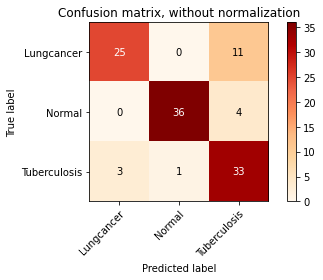

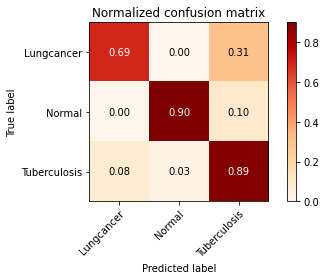

In [ ]:
y_pred = pred_model.argmax(axis=1)            ##
y_true  = y_test_Incep.argmax(axis=1)
y_test = y_test_Incep.argmax(axis=1)

class_names = le_Incep.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 8 soft fine bi adam
0.823


In [ ]:
BS = 8
filepath = "model8_soft_fine_bi_adam.h5"                  ##

train_img_Incep = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (299, 299))                                      
    train_img_Incep.append(img)
data_Incep = np.array(train_img_Incep, dtype="float32") / 255.0

labels_Incep = np.array(data_train3[['NameType']] )        
labels_Incep.shape = (len(labels_Incep),) 
le_Incep = LabelEncoder()                                                                     
labels_Incep = le_Incep.fit_transform(labels_Incep)                                         
labels_Incep = to_categorical(labels_Incep, num_classes=3)                   

aug = ImageDataGenerator( rotation_range=15,	width_shift_range=0.1, 	height_shift_range=0.1,
		shear_range=0.15, 	horizontal_flip=True, 	fill_mode="nearest")
                                                                                                           ## 
callback = EarlyStopping( monitor= "val_accuracy",    patience=15,       mode="max")

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
                                                                                                            ##
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,   patience=6,     verbose=1, mode='max', min_lr=0.00001)

(x_train_Incep, x_test_Incep, y_train_Incep, y_test_Incep ) = train_test_split(data_Incep, labels_Incep,
	                                                                                                test_size=0.25, random_state=40)

100%|██████████| 450/450 [00:05<00:00, 82.54it/s] 


In [ ]:
base_model_Incep = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3), include_top=False, weights="imagenet")
len(base_model_Incep.layers)

base_model_Incep.trainable = True
for layer in base_model_Incep.layers[:100]:    #fix w & bias in layer 0-100
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Incep.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Incep = tf.keras.models.Model(inputs=base_model_Incep.input, outputs=prediction_layer)

model_Incep.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

H_Incep = model_Incep.fit( x=aug.flow(x_train_Incep, y_train_Incep, batch_size=BS),
	                                            validation_data=(x_test_Incep, y_test_Incep),
	                                            steps_per_epoch=len(x_train_Incep) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

pred_Incep = model_Incep.predict(x_test_Incep)

print(classification_report(y_test_Incep.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Incep.argmax(axis=1),  
                                        target_names=le_Incep.classes_))


Epoch 1/100
42/42 [==============================] - ETA: 0s - loss: 0.5072 - accuracy: 0.6231
Epoch 1: val_accuracy improved from -inf to 0.43363, saving model to model8_soft_fine_bi_adam.h5
42/42 [==============================] - 24s 343ms/step - loss: 0.5072 - accuracy: 0.6231 - val_loss: 0.7087 - val_accuracy: 0.4336 - lr: 1.0000e-04
Epoch 2/100
42/42 [==============================] - ETA: 0s - loss: 0.3586 - accuracy: 0.7629
Epoch 2: val_accuracy improved from 0.43363 to 0.59292, saving model to model8_soft_fine_bi_adam.h5
42/42 [==============================] - 13s 305ms/step - loss: 0.3586 - accuracy: 0.7629 - val_loss: 0.5776 - val_accuracy: 0.5929 - lr: 1.0000e-04
Epoch 3/100
42/42 [==============================] - ETA: 0s - loss: 0.2654 - accuracy: 0.8754
Epoch 3: val_accuracy improved from 0.59292 to 0.66372, saving model to model8_soft_fine_bi_adam.h5
42/42 [==============================] - 13s 311ms/step - loss: 0.2654 - accuracy: 0.8754 - val_loss: 0.5979 - val_accur

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

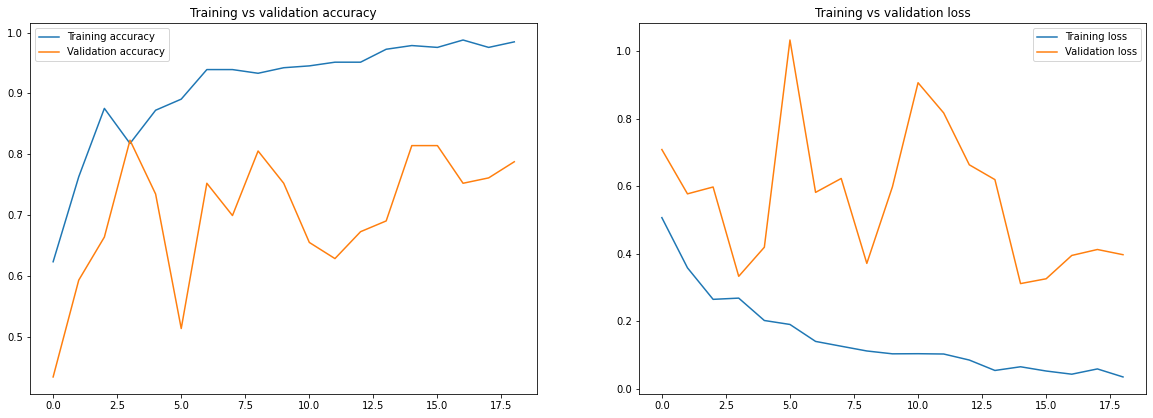

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H_Incep                            ##
pred_Dense = pred_Incep                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[19  0 17]
 [ 0 35  5]
 [ 1  1 35]]
Normalized confusion matrix
[[0.53 0.   0.47]
 [0.   0.88 0.12]
 [0.03 0.03 0.95]]


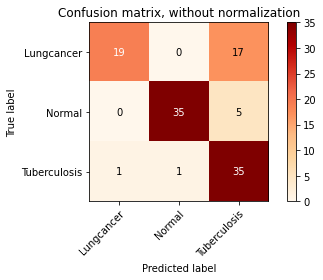

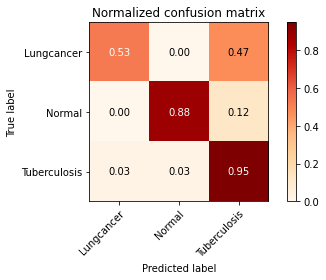

In [ ]:
y_pred = pred_Incep.argmax(axis=1)            ##
y_true  = y_test_Incep.argmax(axis=1)
y_test = y_test_Incep.argmax(axis=1)
class_names = le_Incep.classes_
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [ ]:
model = load_model(filepath)

In [ ]:
pred_model = model.predict(x_test_Incep)

print(classification_report(y_test_Incep.argmax(axis=1),   pred_model.argmax(axis=1), target_names=le_Incep.classes_))

              precision    recall  f1-score   support

  Lungcancer       0.95      0.56      0.70        36
      Normal       0.95      0.97      0.96        40
Tuberculosis       0.67      0.92      0.77        37

    accuracy                           0.82       113
   macro avg       0.86      0.82      0.81       113
weighted avg       0.86      0.82      0.82       113



Confusion matrix, without normalization
[[20  0 16]
 [ 0 39  1]
 [ 1  2 34]]
Normalized confusion matrix
[[0.56 0.   0.44]
 [0.   0.97 0.03]
 [0.03 0.05 0.92]]


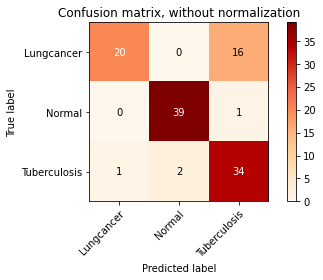

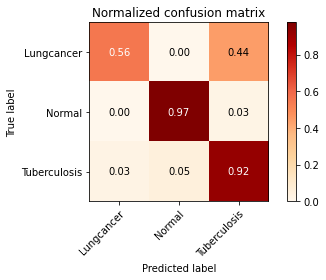

In [ ]:
y_pred = pred_model.argmax(axis=1)            ##
y_true  = y_test_Incep.argmax(axis=1)
y_test = y_test_Incep.argmax(axis=1)

class_names = le_Incep.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 16 soft fine bi 
0.841


In [ ]:
BS = 16
filepath = "model16_soft_fine_bi.h5"                  ##

train_img_Incep = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (299, 299))                                      
    train_img_Incep.append(img)
data_Incep = np.array(train_img_Incep, dtype="float32") / 255.0

labels_Incep = np.array(data_train3[['NameType']] )        
labels_Incep.shape = (len(labels_Incep),) 
le_Incep = LabelEncoder()                                                                     
labels_Incep = le_Incep.fit_transform(labels_Incep)                                         
labels_Incep = to_categorical(labels_Incep, num_classes=3)                   

aug = ImageDataGenerator( rotation_range=15,	width_shift_range=0.1, 	height_shift_range=0.1,
		shear_range=0.15, 	horizontal_flip=True, 	fill_mode="nearest")
                                                                                                           ## 
callback = EarlyStopping( monitor= "val_accuracy",    patience=15,       mode="max")

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
                                                                                                            ##
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,   patience=6,     verbose=1, mode='max', min_lr=0.00001)

(x_train_Incep, x_test_Incep, y_train_Incep, y_test_Incep ) = train_test_split(data_Incep, labels_Incep,
	                                                                                                test_size=0.25, random_state=40)

100%|██████████| 450/450 [00:05<00:00, 81.38it/s] 


In [ ]:
base_model_Incep = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3), include_top=False, weights="imagenet")
len(base_model_Incep.layers)

base_model_Incep.trainable = True
for layer in base_model_Incep.layers[:100]:    #fix w & bias in layer 0-100
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Incep.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Incep = tf.keras.models.Model(inputs=base_model_Incep.input, outputs=prediction_layer)

model_Incep.compile(optimizer=RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

H_Incep = model_Incep.fit( x=aug.flow(x_train_Incep, y_train_Incep, batch_size=BS),
	                                            validation_data=(x_test_Incep, y_test_Incep),
	                                            steps_per_epoch=len(x_train_Incep) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

pred_Incep = model_Incep.predict(x_test_Incep)

print(classification_report(y_test_Incep.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Incep.argmax(axis=1),  
                                        target_names=le_Incep.classes_))


Epoch 1/100
21/21 [==============================] - ETA: 0s - loss: 0.4994 - accuracy: 0.5919
Epoch 1: val_accuracy improved from -inf to 0.46903, saving model to model16_soft_fine_bi.h5
21/21 [==============================] - 26s 664ms/step - loss: 0.4994 - accuracy: 0.5919 - val_loss: 0.6905 - val_accuracy: 0.4690 - lr: 1.0000e-04
Epoch 2/100
21/21 [==============================] - ETA: 0s - loss: 0.3628 - accuracy: 0.7383
Epoch 2: val_accuracy improved from 0.46903 to 0.64602, saving model to model16_soft_fine_bi.h5
21/21 [==============================] - 12s 556ms/step - loss: 0.3628 - accuracy: 0.7383 - val_loss: 0.5259 - val_accuracy: 0.6460 - lr: 1.0000e-04
Epoch 3/100
21/21 [==============================] - ETA: 0s - loss: 0.2315 - accuracy: 0.8723
Epoch 3: val_accuracy did not improve from 0.64602
21/21 [==============================] - 11s 501ms/step - loss: 0.2315 - accuracy: 0.8723 - val_loss: 0.6497 - val_accuracy: 0.6283 - lr: 1.0000e-04
Epoch 4/100
21/21 [=========

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

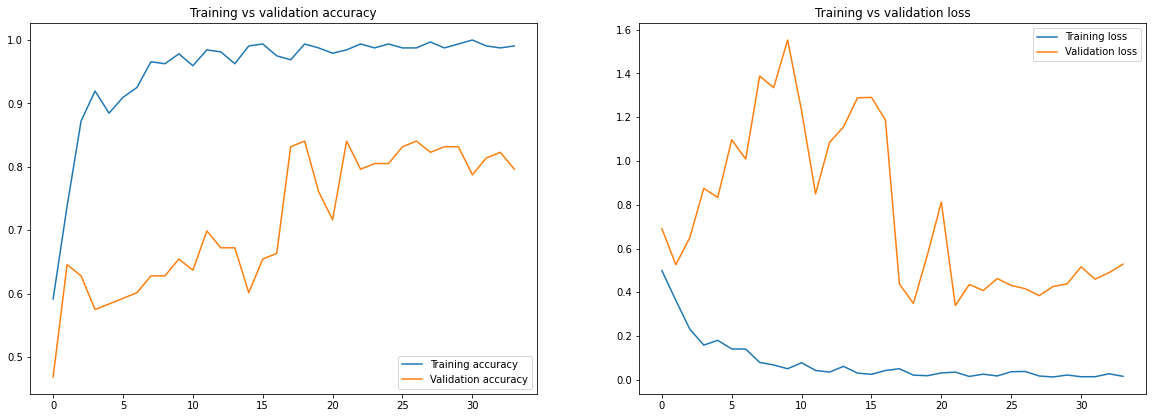

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H_Incep                            ##
pred_Dense = pred_Incep                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[16  0 20]
 [ 0 38  2]
 [ 1  0 36]]
Normalized confusion matrix
[[0.44 0.   0.56]
 [0.   0.95 0.05]
 [0.03 0.   0.97]]


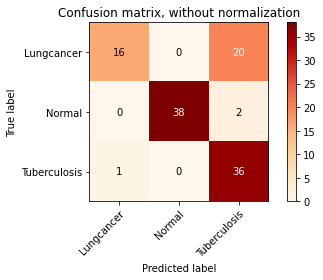

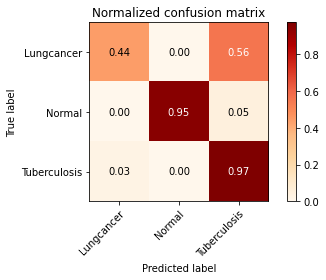

In [ ]:
y_pred = pred_Incep.argmax(axis=1)            ##
y_true  = y_test_Incep.argmax(axis=1)
y_test = y_test_Incep.argmax(axis=1)
class_names = le_Incep.classes_
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [ ]:
model = load_model(filepath)

In [ ]:
pred_model = model.predict(x_test_Incep)

print(classification_report(y_test_Incep.argmax(axis=1),   pred_model.argmax(axis=1), target_names=le_Incep.classes_))

              precision    recall  f1-score   support

  Lungcancer       0.92      0.67      0.77        36
      Normal       0.95      0.95      0.95        40
Tuberculosis       0.70      0.89      0.79        37

    accuracy                           0.84       113
   macro avg       0.86      0.84      0.84       113
weighted avg       0.86      0.84      0.84       113



Confusion matrix, without normalization
[[24  0 12]
 [ 0 38  2]
 [ 2  2 33]]
Normalized confusion matrix
[[0.67 0.   0.33]
 [0.   0.95 0.05]
 [0.05 0.05 0.89]]


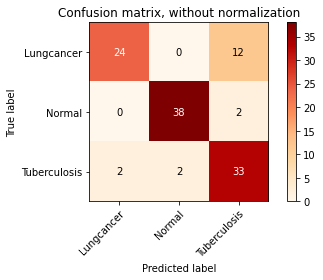

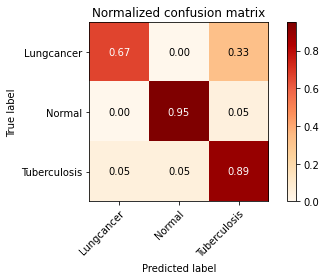

In [ ]:
y_pred = pred_model.argmax(axis=1)            ##
y_true  = y_test_Incep.argmax(axis=1)
y_test = y_test_Incep.argmax(axis=1)

class_names = le_Incep.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 16 soft fine bi adam
0.814


In [ ]:
BS = 16
filepath = "model16_soft_fine_bi_adam.h5"                  ##

train_img_Incep = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (299, 299))                                      
    train_img_Incep.append(img)
data_Incep = np.array(train_img_Incep, dtype="float32") / 255.0

labels_Incep = np.array(data_train3[['NameType']] )        
labels_Incep.shape = (len(labels_Incep),) 
le_Incep = LabelEncoder()                                                                     
labels_Incep = le_Incep.fit_transform(labels_Incep)                                         
labels_Incep = to_categorical(labels_Incep, num_classes=3)                   

aug = ImageDataGenerator( rotation_range=15,	width_shift_range=0.1, 	height_shift_range=0.1,
		shear_range=0.15, 	horizontal_flip=True, 	fill_mode="nearest")
                                                                                                           ## 
callback = EarlyStopping( monitor= "val_accuracy",    patience=15,       mode="max")

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
                                                                                                            ##
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,   patience=6,     verbose=1, mode='max', min_lr=0.00001)

(x_train_Incep, x_test_Incep, y_train_Incep, y_test_Incep ) = train_test_split(data_Incep, labels_Incep,
	                                                                                                test_size=0.25, random_state=40)

100%|██████████| 450/450 [00:05<00:00, 78.52it/s] 


In [ ]:
base_model_Incep = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3), include_top=False, weights="imagenet")
len(base_model_Incep.layers)

base_model_Incep.trainable = True
for layer in base_model_Incep.layers[:100]:    #fix w & bias in layer 0-100
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Incep.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Incep = tf.keras.models.Model(inputs=base_model_Incep.input, outputs=prediction_layer)

model_Incep.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

H_Incep = model_Incep.fit( x=aug.flow(x_train_Incep, y_train_Incep, batch_size=BS),
	                                            validation_data=(x_test_Incep, y_test_Incep),
	                                            steps_per_epoch=len(x_train_Incep) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

pred_Incep = model_Incep.predict(x_test_Incep)

print(classification_report(y_test_Incep.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Incep.argmax(axis=1),  
                                        target_names=le_Incep.classes_))


Epoch 1/100
21/21 [==============================] - ETA: 0s - loss: 0.5431 - accuracy: 0.5981
Epoch 1: val_accuracy improved from -inf to 0.38938, saving model to model16_soft_fine_bi_adam.h5
21/21 [==============================] - 25s 676ms/step - loss: 0.5431 - accuracy: 0.5981 - val_loss: 0.7485 - val_accuracy: 0.3894 - lr: 1.0000e-04
Epoch 2/100
21/21 [==============================] - ETA: 0s - loss: 0.3489 - accuracy: 0.7695
Epoch 2: val_accuracy improved from 0.38938 to 0.54867, saving model to model16_soft_fine_bi_adam.h5
21/21 [==============================] - 12s 560ms/step - loss: 0.3489 - accuracy: 0.7695 - val_loss: 0.6498 - val_accuracy: 0.5487 - lr: 1.0000e-04
Epoch 3/100
21/21 [==============================] - ETA: 0s - loss: 0.2224 - accuracy: 0.8785
Epoch 3: val_accuracy did not improve from 0.54867
21/21 [==============================] - 10s 492ms/step - loss: 0.2224 - accuracy: 0.8785 - val_loss: 0.8737 - val_accuracy: 0.5133 - lr: 1.0000e-04
Epoch 4/100
21/21 

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

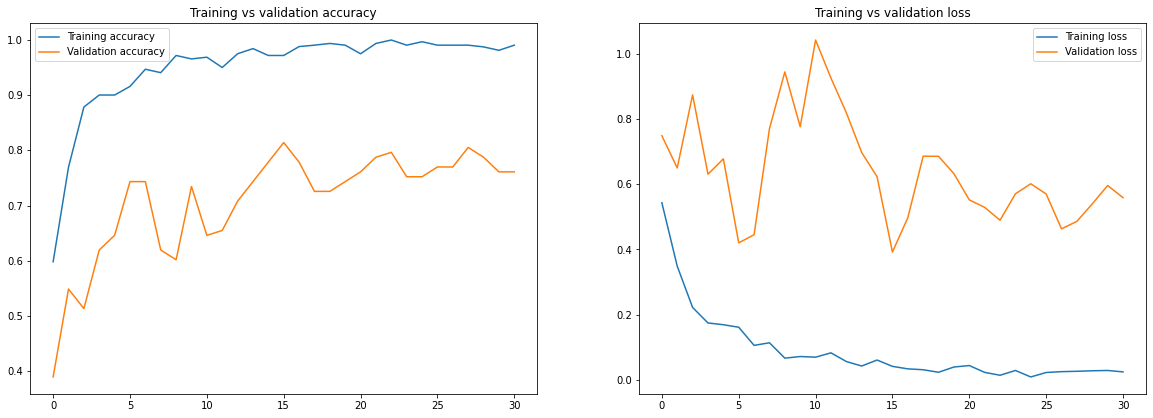

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H_Incep                            ##
pred_Dense = pred_Incep                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[16  0 20]
 [ 0 35  5]
 [ 1  1 35]]
Normalized confusion matrix
[[0.44 0.   0.56]
 [0.   0.88 0.12]
 [0.03 0.03 0.95]]


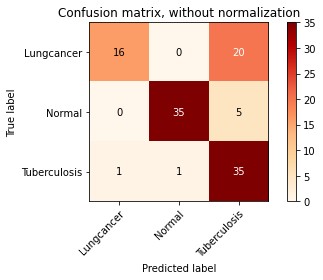

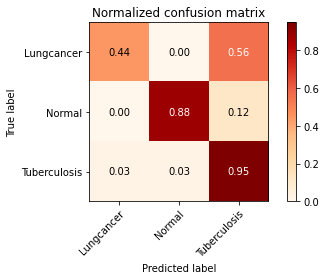

In [ ]:
y_pred = pred_Incep.argmax(axis=1)            ##
y_true  = y_test_Incep.argmax(axis=1)
y_test = y_test_Incep.argmax(axis=1)
class_names = le_Incep.classes_
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [ ]:
model = load_model(filepath)

In [ ]:
pred_model = model.predict(x_test_Incep)

print(classification_report(y_test_Incep.argmax(axis=1),   pred_model.argmax(axis=1), target_names=le_Incep.classes_))

              precision    recall  f1-score   support

  Lungcancer       0.95      0.58      0.72        36
      Normal       0.95      0.93      0.94        40
Tuberculosis       0.65      0.92      0.76        37

    accuracy                           0.81       113
   macro avg       0.85      0.81      0.81       113
weighted avg       0.85      0.81      0.81       113



Confusion matrix, without normalization
[[21  0 15]
 [ 0 37  3]
 [ 1  2 34]]
Normalized confusion matrix
[[0.58 0.   0.42]
 [0.   0.93 0.07]
 [0.03 0.05 0.92]]


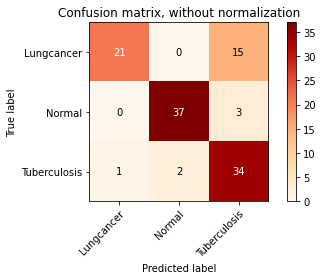

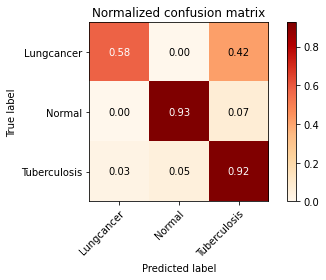

In [ ]:
y_pred = pred_model.argmax(axis=1)            ##
y_true  = y_test_Incep.argmax(axis=1)
y_test = y_test_Incep.argmax(axis=1)

class_names = le_Incep.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 32 soft fine bi 
0.876


In [ ]:
BS = 32
filepath = "model32_soft_fine_bi.h5"                  ##

train_img_Incep = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (299, 299))                                      
    train_img_Incep.append(img)
data_Incep = np.array(train_img_Incep, dtype="float32") / 255.0

labels_Incep = np.array(data_train3[['NameType']] )        
labels_Incep.shape = (len(labels_Incep),) 
le_Incep = LabelEncoder()                                                                     
labels_Incep = le_Incep.fit_transform(labels_Incep)                                         
labels_Incep = to_categorical(labels_Incep, num_classes=3)                   

aug = ImageDataGenerator( rotation_range=15,	width_shift_range=0.1, 	height_shift_range=0.1,
		shear_range=0.15, 	horizontal_flip=True, 	fill_mode="nearest")
                                                                                                           ## 
callback = EarlyStopping( monitor= "val_accuracy",    patience=15,       mode="max")

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
                                                                                                            ##
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,   patience=6,     verbose=1, mode='max', min_lr=0.00001)

(x_train_Incep, x_test_Incep, y_train_Incep, y_test_Incep ) = train_test_split(data_Incep, labels_Incep,
	                                                                                                test_size=0.25, random_state=40)

100%|██████████| 450/450 [00:05<00:00, 80.76it/s] 


In [ ]:
base_model_Incep = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3), include_top=False, weights="imagenet")
len(base_model_Incep.layers)

base_model_Incep.trainable = True
for layer in base_model_Incep.layers[:100]:    #fix w & bias in layer 0-100
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Incep.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Incep = tf.keras.models.Model(inputs=base_model_Incep.input, outputs=prediction_layer)

model_Incep.compile(optimizer=RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

H_Incep = model_Incep.fit( x=aug.flow(x_train_Incep, y_train_Incep, batch_size=BS),
	                                            validation_data=(x_test_Incep, y_test_Incep),
	                                            steps_per_epoch=len(x_train_Incep) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

pred_Incep = model_Incep.predict(x_test_Incep)

print(classification_report(y_test_Incep.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Incep.argmax(axis=1),  
                                        target_names=le_Incep.classes_))


Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 0.5389 - accuracy: 0.6098
Epoch 1: val_accuracy improved from -inf to 0.36283, saving model to model32_soft_fine_bi.h5
10/10 [==============================] - 24s 1s/step - loss: 0.5389 - accuracy: 0.6098 - val_loss: 0.9308 - val_accuracy: 0.3628 - lr: 1.0000e-04
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 0.3336 - accuracy: 0.8000
Epoch 2: val_accuracy improved from 0.36283 to 0.43363, saving model to model32_soft_fine_bi.h5
10/10 [==============================] - 11s 1s/step - loss: 0.3336 - accuracy: 0.8000 - val_loss: 0.9081 - val_accuracy: 0.4336 - lr: 1.0000e-04
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.2395 - accuracy: 0.8656
Epoch 3: val_accuracy did not improve from 0.43363
10/10 [==============================] - 10s 934ms/step - loss: 0.2395 - accuracy: 0.8656 - val_loss: 1.1151 - val_accuracy: 0.4071 - lr: 1.0000e-04
Epoch 4/100
10/10 [===============

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

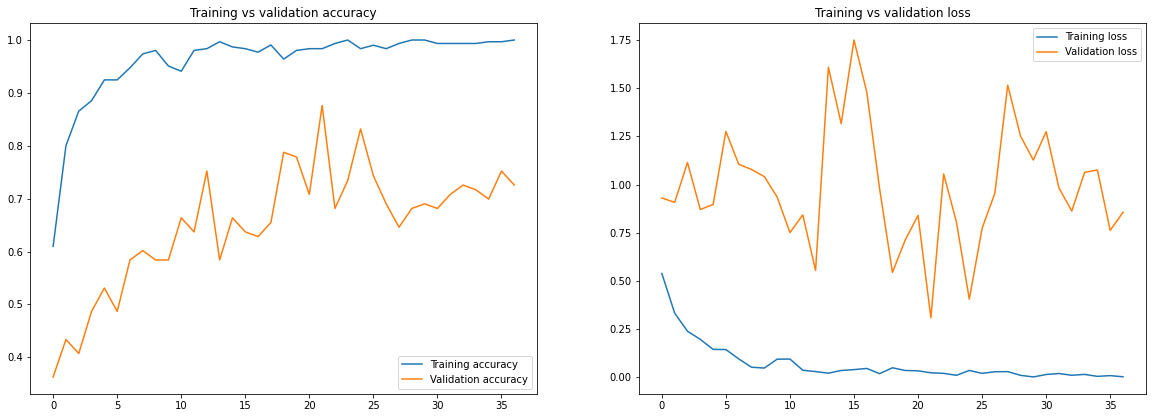

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H_Incep                            ##
pred_Dense = pred_Incep                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[ 9  5 22]
 [ 0 38  2]
 [ 0  2 35]]
Normalized confusion matrix
[[0.25 0.14 0.61]
 [0.   0.95 0.05]
 [0.   0.05 0.95]]


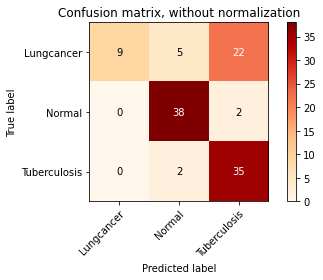

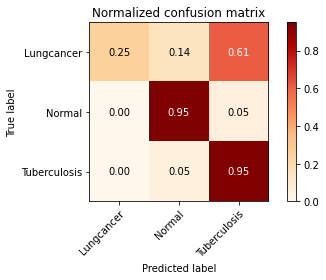

In [ ]:
y_pred = pred_Incep.argmax(axis=1)            ##
y_true  = y_test_Incep.argmax(axis=1)
y_test = y_test_Incep.argmax(axis=1)
class_names = le_Incep.classes_
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [ ]:
model = load_model(filepath)

In [ ]:
pred_model = model.predict(x_test_Incep)

print(classification_report(y_test_Incep.argmax(axis=1),   pred_model.argmax(axis=1), target_names=le_Incep.classes_))

              precision    recall  f1-score   support

  Lungcancer       0.96      0.75      0.84        36
      Normal       0.91      0.97      0.94        40
Tuberculosis       0.79      0.89      0.84        37

    accuracy                           0.88       113
   macro avg       0.89      0.87      0.87       113
weighted avg       0.89      0.88      0.88       113



Confusion matrix, without normalization
[[27  1  8]
 [ 0 39  1]
 [ 1  3 33]]
Normalized confusion matrix
[[0.75 0.03 0.22]
 [0.   0.97 0.03]
 [0.03 0.08 0.89]]


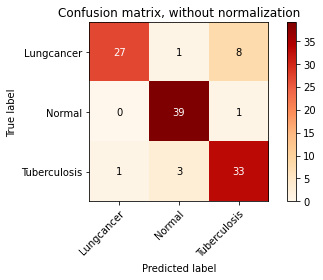

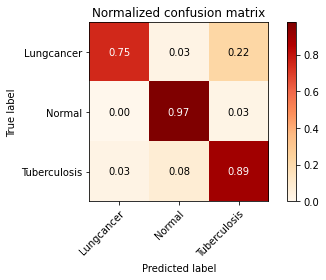

In [ ]:
y_pred = pred_model.argmax(axis=1)            ##
y_true  = y_test_Incep.argmax(axis=1)
y_test = y_test_Incep.argmax(axis=1)

class_names = le_Incep.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 32 soft fine bi adam
0.797


In [ ]:
BS = 32
filepath = "model32_soft_fine_bi_adam.h5"                  ##

train_img_Incep = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (299, 299))                                      
    train_img_Incep.append(img)
data_Incep = np.array(train_img_Incep, dtype="float32") / 255.0

labels_Incep = np.array(data_train3[['NameType']] )        
labels_Incep.shape = (len(labels_Incep),) 
le_Incep = LabelEncoder()                                                                     
labels_Incep = le_Incep.fit_transform(labels_Incep)                                         
labels_Incep = to_categorical(labels_Incep, num_classes=3)                   

aug = ImageDataGenerator( rotation_range=15,	width_shift_range=0.1, 	height_shift_range=0.1,
		shear_range=0.15, 	horizontal_flip=True, 	fill_mode="nearest")
                                                                                                           ## 
callback = EarlyStopping( monitor= "val_accuracy",    patience=15,       mode="max")

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
                                                                                                            ##
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,   patience=6,     verbose=1, mode='max', min_lr=0.00001)

(x_train_Incep, x_test_Incep, y_train_Incep, y_test_Incep ) = train_test_split(data_Incep, labels_Incep,
	                                                                                                test_size=0.25, random_state=40)

100%|██████████| 450/450 [00:05<00:00, 82.40it/s] 


In [ ]:
base_model_Incep = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3), include_top=False, weights="imagenet")
len(base_model_Incep.layers)

base_model_Incep.trainable = True
for layer in base_model_Incep.layers[:100]:    #fix w & bias in layer 0-100
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Incep.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Incep = tf.keras.models.Model(inputs=base_model_Incep.input, outputs=prediction_layer)

model_Incep.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

H_Incep = model_Incep.fit( x=aug.flow(x_train_Incep, y_train_Incep, batch_size=BS),
	                                            validation_data=(x_test_Incep, y_test_Incep),
	                                            steps_per_epoch=len(x_train_Incep) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

pred_Incep = model_Incep.predict(x_test_Incep)

print(classification_report(y_test_Incep.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Incep.argmax(axis=1),  
                                        target_names=le_Incep.classes_))


Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 0.5320 - accuracy: 0.6295
Epoch 1: val_accuracy improved from -inf to 0.35398, saving model to model32_soft_fine_bi_adam.h5
10/10 [==============================] - 24s 2s/step - loss: 0.5320 - accuracy: 0.6295 - val_loss: 0.7399 - val_accuracy: 0.3540 - lr: 1.0000e-04
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 0.3577 - accuracy: 0.7803
Epoch 2: val_accuracy improved from 0.35398 to 0.39823, saving model to model32_soft_fine_bi_adam.h5
10/10 [==============================] - 11s 1s/step - loss: 0.3577 - accuracy: 0.7803 - val_loss: 0.7421 - val_accuracy: 0.3982 - lr: 1.0000e-04
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.2751 - accuracy: 0.8328
Epoch 3: val_accuracy did not improve from 0.39823
10/10 [==============================] - 10s 956ms/step - loss: 0.2751 - accuracy: 0.8328 - val_loss: 0.8621 - val_accuracy: 0.3982 - lr: 1.0000e-04
Epoch 4/100
10/10 [=====

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

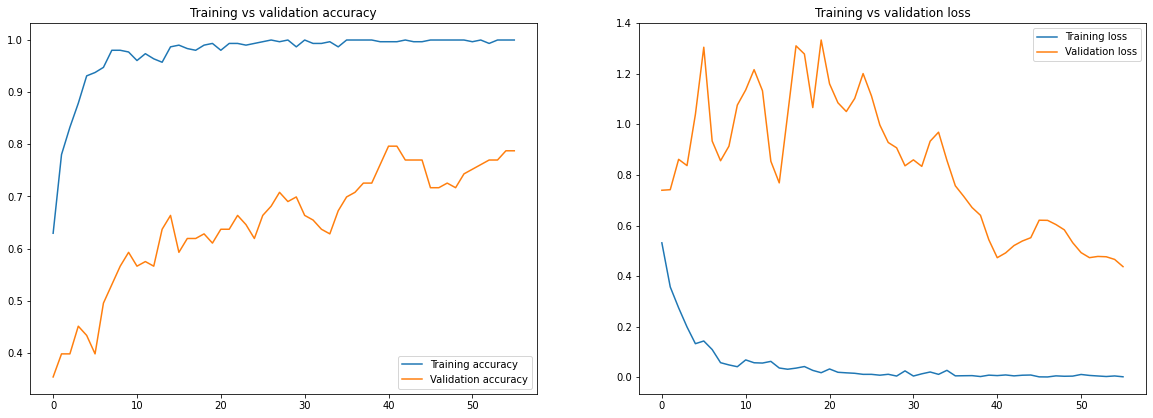

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H_Incep                            ##
pred_Dense = pred_Incep                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[16  0 20]
 [ 0 38  2]
 [ 1  1 35]]
Normalized confusion matrix
[[0.44 0.   0.56]
 [0.   0.95 0.05]
 [0.03 0.03 0.95]]


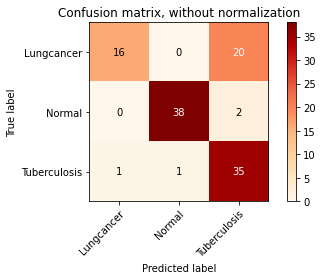

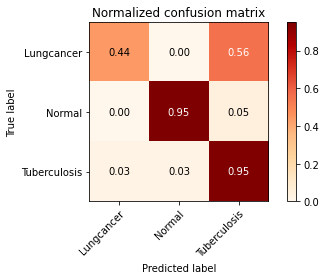

In [ ]:
y_pred = pred_Incep.argmax(axis=1)            ##
y_true  = y_test_Incep.argmax(axis=1)
y_test = y_test_Incep.argmax(axis=1)
class_names = le_Incep.classes_
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [ ]:
model = load_model(filepath)

In [ ]:
pred_model = model.predict(x_test_Incep)

print(classification_report(y_test_Incep.argmax(axis=1),   pred_model.argmax(axis=1), target_names=le_Incep.classes_))

              precision    recall  f1-score   support

  Lungcancer       0.95      0.50      0.65        36
      Normal       0.95      0.95      0.95        40
Tuberculosis       0.63      0.92      0.75        37

    accuracy                           0.80       113
   macro avg       0.84      0.79      0.78       113
weighted avg       0.84      0.80      0.79       113



Confusion matrix, without normalization
[[18  0 18]
 [ 0 38  2]
 [ 1  2 34]]
Normalized confusion matrix
[[0.5  0.   0.5 ]
 [0.   0.95 0.05]
 [0.03 0.05 0.92]]


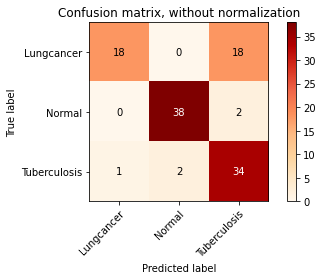

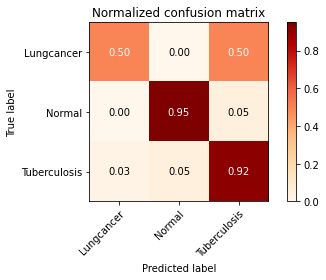

In [ ]:
y_pred = pred_model.argmax(axis=1)            ##
y_true  = y_test_Incep.argmax(axis=1)
y_test = y_test_Incep.argmax(axis=1)

class_names = le_Incep.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()